In [377]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)

In [378]:
df = pd.read_excel("data/survey-data-tacr-dotaznik-pro-praktikujici-projektove-manazery.xlsx")
df_students = pd.read_excel("data/survey-data-tacr-dotaznik-pro-studenty-na-zacatku-kurzu.xlsx")

In [379]:
def plot_highest_and_lowest_avgs(df, top_10_description, bottom_10_description=None, hue_string=None, legend_title=None, filter_hue=None, x_label=""):
    if hue_string:
        column_means = df.drop(columns=[hue_string]).mean()
    else:
        column_means = df.mean()

    # Sort the means and select the top 10 and bottom 10 columns
    if hue_string is None:
        top_10_columns = column_means.nlargest(38).index.tolist()
        bottom_10_columns = column_means.nsmallest(19).iloc[::-1].index.tolist()
    else:
        value_counts = df[hue_string].value_counts()
        if len(value_counts) == 2:
            sorted_unique_hues = value_counts.index.tolist()
            df_ano = df[df[hue_string] == sorted_unique_hues[0]]
            df_ne = df[df[hue_string] == sorted_unique_hues[1]]
            mean_ano = df_ano.drop(columns=[hue_string]).mean()
            mean_ne = df_ne.drop(columns=[hue_string]).mean()
            diff_means = abs(mean_ano - mean_ne)
        else:
            group_means = df.groupby(hue_string).mean()
            column_variability = group_means.std()
            diff_means = column_variability.sort_values(ascending=False)
        top_10_columns = diff_means.nlargest(38).index.tolist()
        bottom_10_columns = diff_means.nsmallest(19).iloc[::-1].index.tolist()

    # Function to create a plot
    def create_barplot(columns, title):
        data_plot = df[columns]
        plt.figure(figsize=(15, 12))
        if hue_string is not None:
            if filter_hue is not None:
                data_plot = data_plot[data_plot[hue_string].isin(filter_hue)]
            data_plot = data_plot.melt(id_vars=hue_string, var_name='x', value_name='y')
            if filter_hue is not None:
                sns.barplot(data=data_plot, x="y", y="x", errorbar=None, hue=hue_string, hue_order=filter_hue)
            else:
                sns.barplot(data=data_plot, x="y", y="x", errorbar=None, hue=hue_string)
        else:
            data_plot = data_plot.melt(var_name='x', value_name='y')
            sns.barplot(data=data_plot, x="y", y="x", errorbar="sd", color="royalblue")
        plt.xticks(rotation=45)
        plt.title(title)
        plt.legend(loc='upper right', title=legend_title)
        plt.xlabel(x_label)
        plt.ylabel('')
        plt.show()

    if hue_string is None:
        create_barplot(top_10_columns, top_10_description)
        create_barplot(bottom_10_columns, bottom_10_description)
    else:
        create_barplot(top_10_columns + [hue_string,], top_10_description)
        create_barplot(bottom_10_columns + [hue_string,], top_10_description)
    #create_barplot(top_10_variability_columns, '10 kompetencí s nejvyšší variabilitou využití')
    #create_barplot(bottom_10_variability_columns, '10 kompetencí s nejmenší variabilitou využití')

In [380]:
def plot_correlation(df):
    corr_mat = df.corr().stack().reset_index(name="correlation")
    g = sns.relplot(
        data=corr_mat,
        x="level_0", y="level_1", hue="correlation", size="correlation",
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 150), size_norm=(-.2, .8),
    )
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)

In [381]:
def plot_diff_avg(df_avg, column_1, column_2, title="", x_label=""):
    data = df_avg
    # Determine the color based on whether column_1 is higher than column_2
    data['color'] = data.apply(lambda row: 'green' if row[column_1] > row[column_2] else 'red', axis=1)

    # Calculate the start point and length of each bar
    data['bar_start'] = data[[column_2, column_1]].min(axis=1)
    data['bar_end'] = data[[column_2, column_1]].max(axis=1) - data['bar_start']

    # Calculate the difference between column_2 and column_1 for sorting
    data['difference'] = abs(data[column_2] - data[column_1])

    # Sort data by the difference in descending order
    data_sorted = data.sort_values(by='difference', ascending=True)

    # Create a horizontal bar plot with the sorted data
    plt.figure(figsize=(10, 8))
    bars = plt.barh(data_sorted.index, data_sorted['bar_end'], left=data_sorted['bar_start'], color=data_sorted['color'])

    plt.grid(axis='y', which='major', color='gray', linestyle='--', linewidth=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.xlabel(x_label)

    import matplotlib.patches as mpatches

    description1 = 'Higher average rating for managed'
    description2 = 'Higher average rating for used'
    color1 = 'green'  # Replace with actual color name or hex
    color2 = 'red' # Replace with actual color name or hex

    # Create patches for the legend
    patch1 = mpatches.Patch(color=color1, label=description1)
    patch2 = mpatches.Patch(color=color2, label=description2)

    # Add the legend to the plot
    plt.legend(handles=[patch1, patch2], loc='best')

    # Display the plot
    plt.show()

In [382]:
def update_column_names(df):
    column_name_mapping = {
    'Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu ': 'Req. and project goals',
    'Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) ': 'Project architecture',
    'Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů ': 'Success criteria',
    'Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit ': 'Project schedule',
    'Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření ': 'Monitoring',
    'Posouzení, vyjednání a implementace změny projektu ': 'Change management',
    'Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí ': 'Financial mngt',
    'Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu ': 'Cost estimation',
    'Zajištění finančních zdrojů projektu ': 'Financial sources',
    'Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie ': 'Work packages',
    'Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu ': 'Scope mngt',
    'Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt ': 'Risk analysis',
    'Zpracování a implementace postupu pro řízení rizik ': 'Risk mngt',
    'Monitorování a vyhodnocování rizik, příležitostí a implementace opatření ': 'Risk evaluation',
    'Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření ': 'Quality assurance',
    'Zajištění souladu projektu s prostředím a procesy podniku ': 'Project env. alignment',
    'Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení ': 'Problem identification',
    'Kontrola a vyhodnocení implementovaných řešení problémů ': 'Solution evaluation',
    'Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Mngt structure',
    'Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací ': 'Tools and processes',
    'Volba a efektivní ovládání software pro řízení projektu včetně informačních toků ': 'Software mngt',
    'Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu ': 'Team collaboration',
    'Posilování týmu delegováním úkolů, odpovědností a učením se z chyb ': 'Delegation',
    'Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu ': 'Resource planning',
    'Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí ': 'Resource providers',
    'Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření ': 'Resource allocation',
    'Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu ': 'KPI review',
    'Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů ': 'Analysis techniques',
    'Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění ': 'Communication',
    'Aktivní naslouchání a podpora otevřené komunikace ': 'Active listening',
    'Zajištění efektivní komunikace s virtuálními týmy ': 'Virtual teams',
    'Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) ': 'Labor law',
    'Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů ': 'Stakeholders',
    'Rozhodování a prosazování rozhodnutí a přijímání odpovědnosti ': 'Decision-making',
    'Předvídání a předcházení konfliktům a krizím ': 'Conflict mngt',
    'Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy ': 'Orders and contracts',
    'Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt ': 'Cultural env.',
    'Organizace vlastní práce dle situace a vlastních zdrojů ': 'Self-organization',
    'Definice struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Role definition'
}

    df = df.rename(columns=column_name_mapping)
    return df

In [383]:
column_name_mapping = {
    'Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu ': 'Req. and project goals',
    'Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) ': 'Project architecture',
    'Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů ': 'Success criteria',
    'Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit ': 'Project schedule',
    'Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření ': 'Monitoring',
    'Posouzení, vyjednání a implementace změny projektu ': 'Change management',
    'Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí ': 'Financial mngt',
    'Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu ': 'Cost estimation',
    'Zajištění finančních zdrojů projektu ': 'Financial sources',
    'Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie ': 'Work packages',
    'Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu ': 'Scope mngt',
    'Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt ': 'Risk analysis',
    'Zpracování a implementace postupu pro řízení rizik ': 'Risk mngt',
    'Monitorování a vyhodnocování rizik, příležitostí a implementace opatření ': 'Risk evaluation',
    'Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření ': 'Quality assurance',
    'Zajištění souladu projektu s prostředím a procesy podniku ': 'Project env. alignment',
    'Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení ': 'Problem identification',
    'Kontrola a vyhodnocení implementovaných řešení problémů ': 'Solution evaluation',
    'Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Mngt structure',
    'Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací ': 'Tools and processes',
    'Volba a efektivní ovládání software pro řízení projektu včetně informačních toků ': 'Software mngt',
    'Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu ': 'Team collaboration',
    'Posilování týmu delegováním úkolů, odpovědností a učením se z chyb ': 'Delegation',
    'Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu ': 'Resource planning',
    'Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí ': 'Resource providers',
    'Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření ': 'Resource allocation',
    'Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu ': 'KPI review',
    'Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů ': 'Analysis techniques',
    'Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění ': 'Communication',
    'Aktivní naslouchání a podpora otevřené komunikace ': 'Active listening',
    'Zajištění efektivní komunikace s virtuálními týmy ': 'Virtual teams',
    'Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) ': 'Labor law',
    'Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů ': 'Stakeholders',
    'Rozhodování a prosazování rozhodnutí a přijímání odpovědnosti ': 'Decision-making',
    'Předvídání a předcházení konfliktům a krizím ': 'Conflict mngt',
    'Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy ': 'Orders and contracts',
    'Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt ': 'Cultural env.',
    'Organizace vlastní práce dle situace a vlastních zdrojů ': 'Self-organization',
    'Definice struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Role definition'
}



column_group_mapping = {
    'Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu ': 'Requirements and objectives',
    'Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) ': 'Project design',
    'Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů ': 'Project design',
    'Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit ': ' Time',
    'Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření ': 'Plan and control the project execution',
    "Monitorování, reportování a vyhodnocování průběhu projektu a příjímání nezbytných opatření ": 'Plan and control the project execution',
    'Posouzení, vyjednání a implementace změny projektu ': 'Plan and control the project execution',
    'Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí ': 'Finance',
    'Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu ': 'Finance',
    'Zajištění finančních zdrojů projektu ': 'Finance',
    'Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie ': 'Scope',
    'Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu ': 'Scope',
    'Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt ': 'Risk and opportunity',
    'Zpracování a implementace postupu pro řízení rizik ': 'Risk and opportunity',
    'Monitorování a vyhodnocování rizik, příležitostí a implementace opatření ': 'Risk and opportunity',
    'Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření ': 'Quality',
    'Zajištění souladu projektu s prostředím a procesy podniku ': 'Governance, structures and processes',
    'Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení ': 'Problem solving',
    'Kontrola a vyhodnocení implementovaných řešení problémů ': 'Problem solving',
    'Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Organisation and information',
    'Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací ': 'Organisation and information',
    'Volba a efektivní ovládání software pro řízení projektu včetně informačních toků ': 'Organisation and information',
    'Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu ': 'Teamwork',
    'Posilování týmu delegováním úkolů, odpovědností a učením se z chyb ': 'Teamwork',
    'Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu ': 'Resources',
    'Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí ': 'Resources',
    'Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření ': 'Resources',
    'Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu ': 'Strategy',
    'Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů ': 'Resourcefulness',
    'Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění ': 'Personal communication',
    'Aktivní naslouchání a podpora otevřené komunikace ': 'Personal communication',
    'Zajištění efektivní komunikace s virtuálními týmy ': 'Personal communication',
    'Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) ': 'Compliance, standards and regulations',
    'Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů ': 'Stakeholders',
    'Rozhodování a prosazování rozhodnutí a přijímání odpovědnosti ': 'Leadership',
    "Rozhodování a prosazování rozhodnutí a příjmání odpovědnosti ": "Leadership",
    'Předvídání a předcházení konfliktům a krizím ': 'Conflict and crisis',
    'Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy ': 'Procurement',
    'Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt ': 'Relationships and engagements',
    'Organizace vlastní práce dle situace a vlastních zdrojů ': 'Self-reflection and self-management',
    "Definice struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ": "Teamwork",
}

In [384]:
def count_plot(df, title, y):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y=y)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")


In [385]:
def hue_plot_usage(df_filtered, search_string, title=None, hue_string=None, legend_title=None, filter_hue=None, x_label=""):    
    filtered_columns = [col for col in df_filtered.columns if search_string in col]
    if hue_string:
        filtered_columns += [hue_string, ]
    df_filtered = df_filtered[filtered_columns]
    df_filtered = df_filtered.rename(columns=lambda x: x.replace(search_string, ""))
    df_filtered = update_column_names(df_filtered)
    if hue_string:
        plot_highest_and_lowest_avgs(df_filtered, title, hue_string=hue_string, legend_title=legend_title, filter_hue=filter_hue, x_label=x_label)
    else:
        plot_highest_and_lowest_avgs(df_filtered, title, x_label=x_label)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


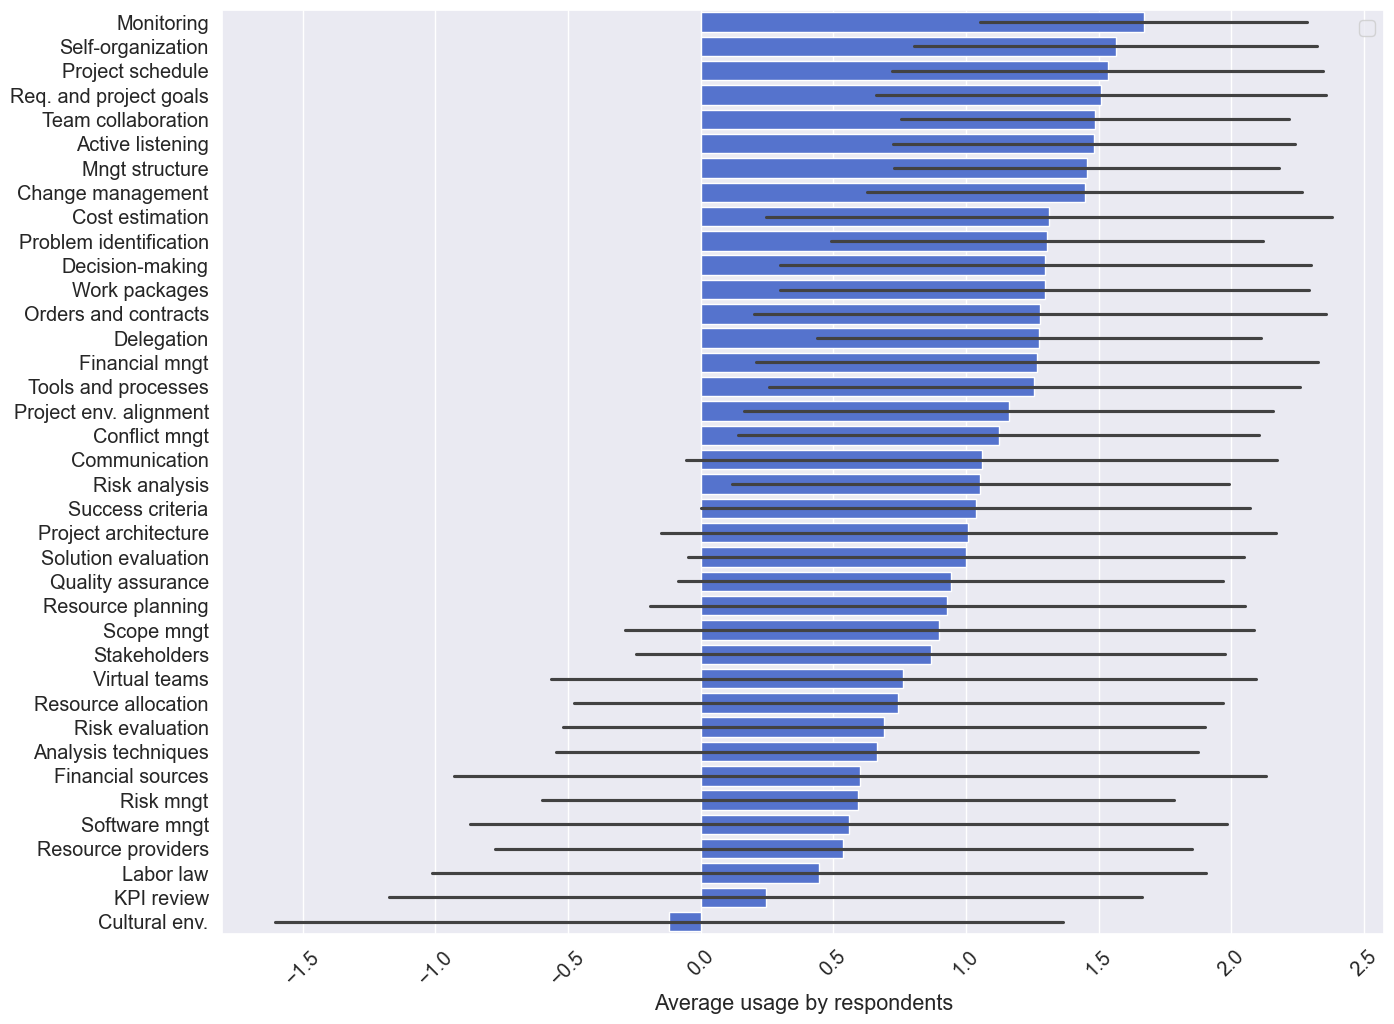

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


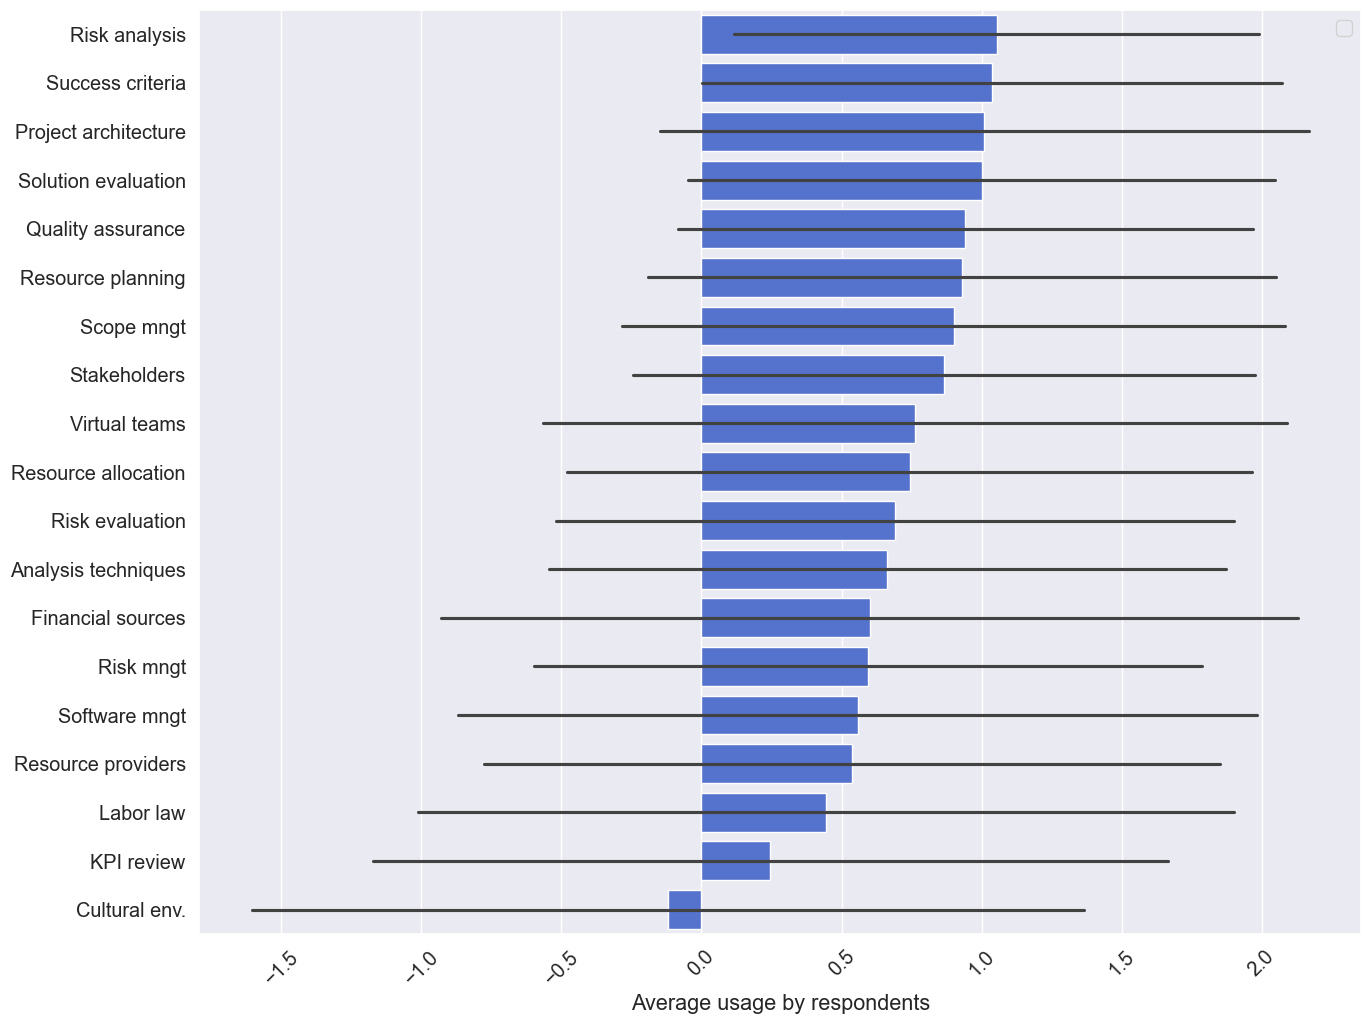

In [386]:
search_string = "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně"

filtered_columns = [col for col in df.columns if search_string in col]
df_filtered_usage = df[filtered_columns]
df_filtered_usage = df_filtered_usage.rename(columns=lambda x: x.replace(search_string, ""))
df_filtered_usage = update_column_names(df_filtered_usage)

hue_plot_usage(df, search_string, x_label="Average usage by respondents")

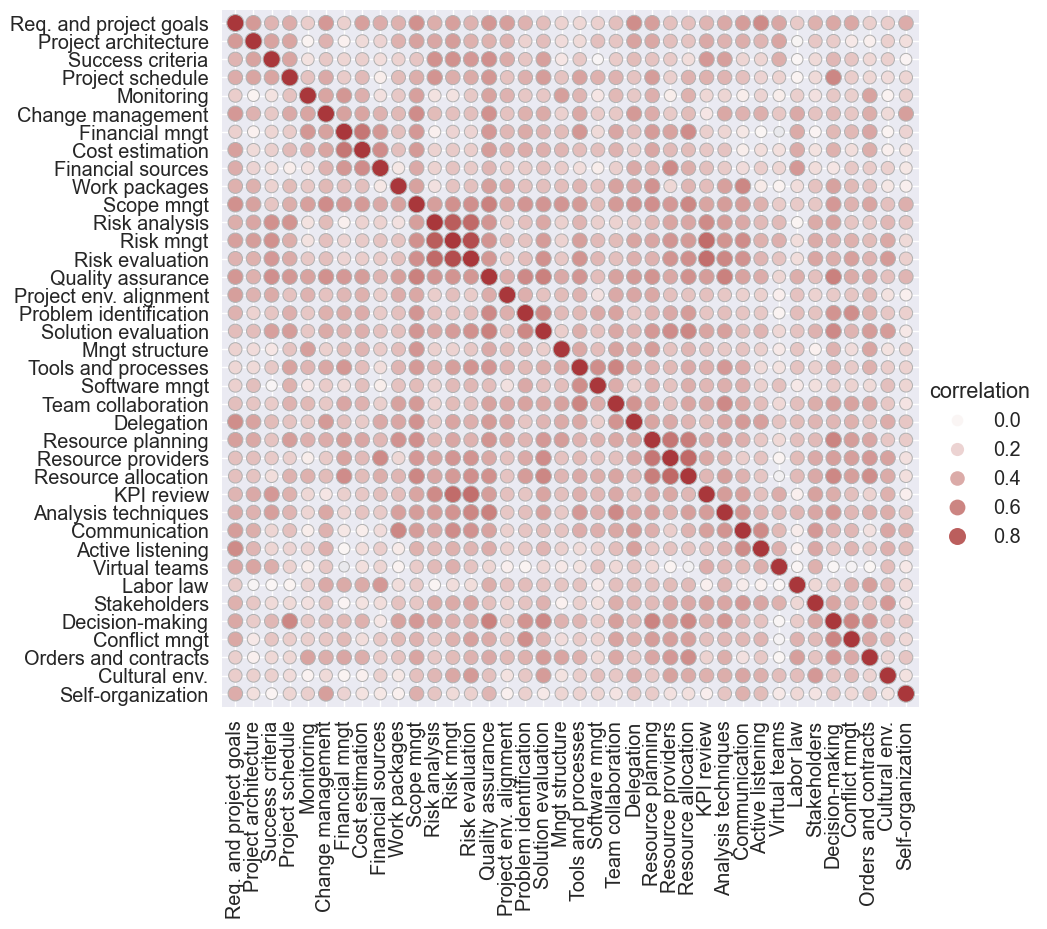

In [387]:
plot_correlation(df_filtered_usage)

In [388]:
df_avg = df_filtered_usage.mean().to_frame(name="Využití")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


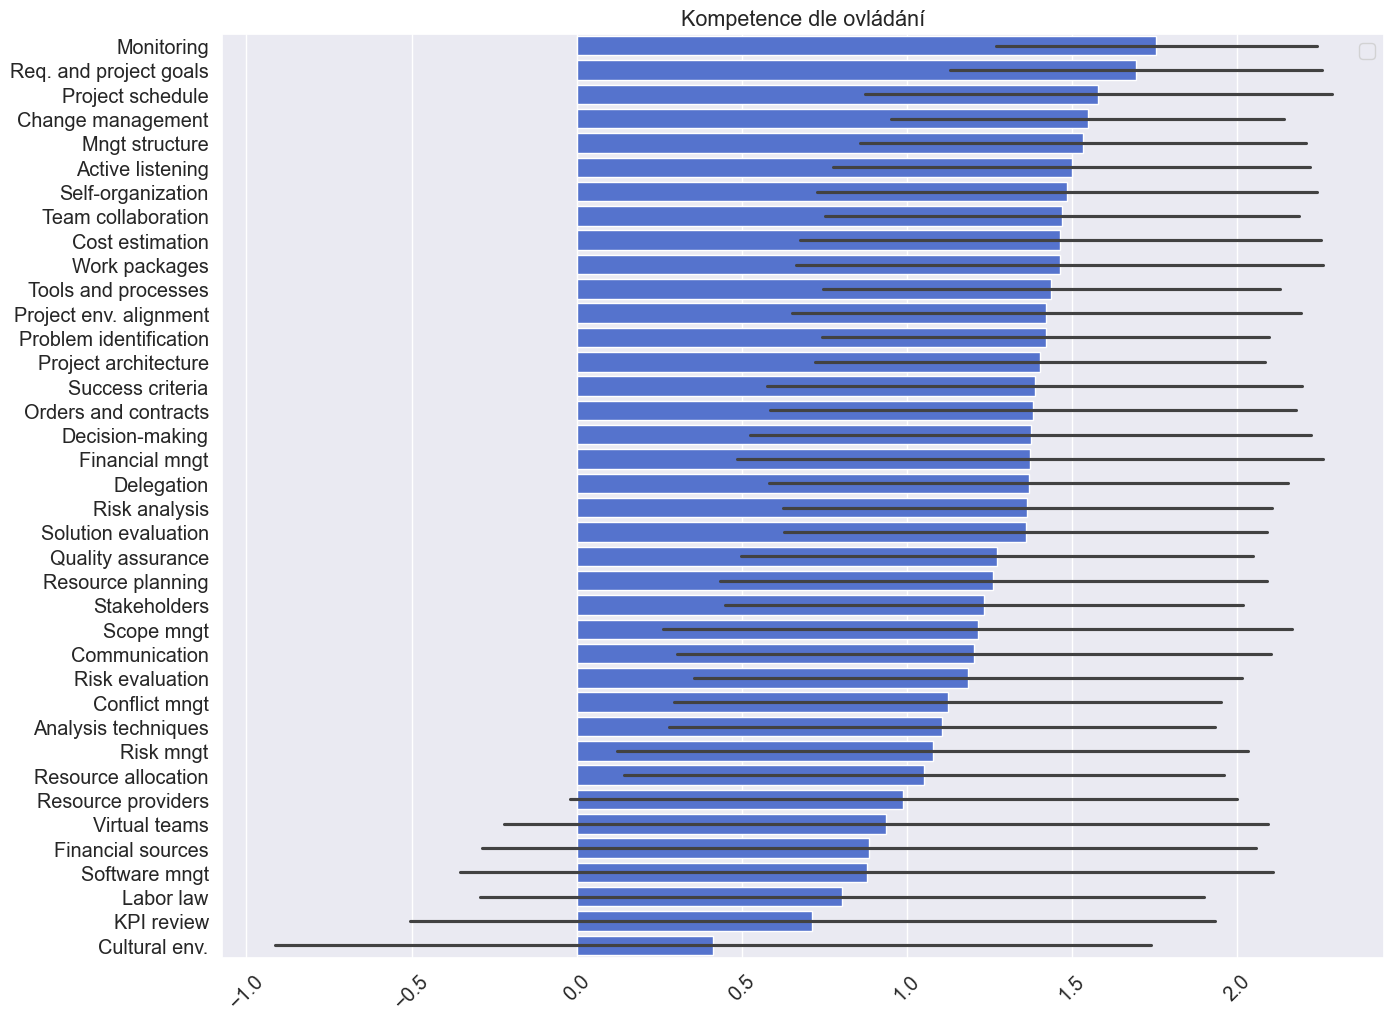

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


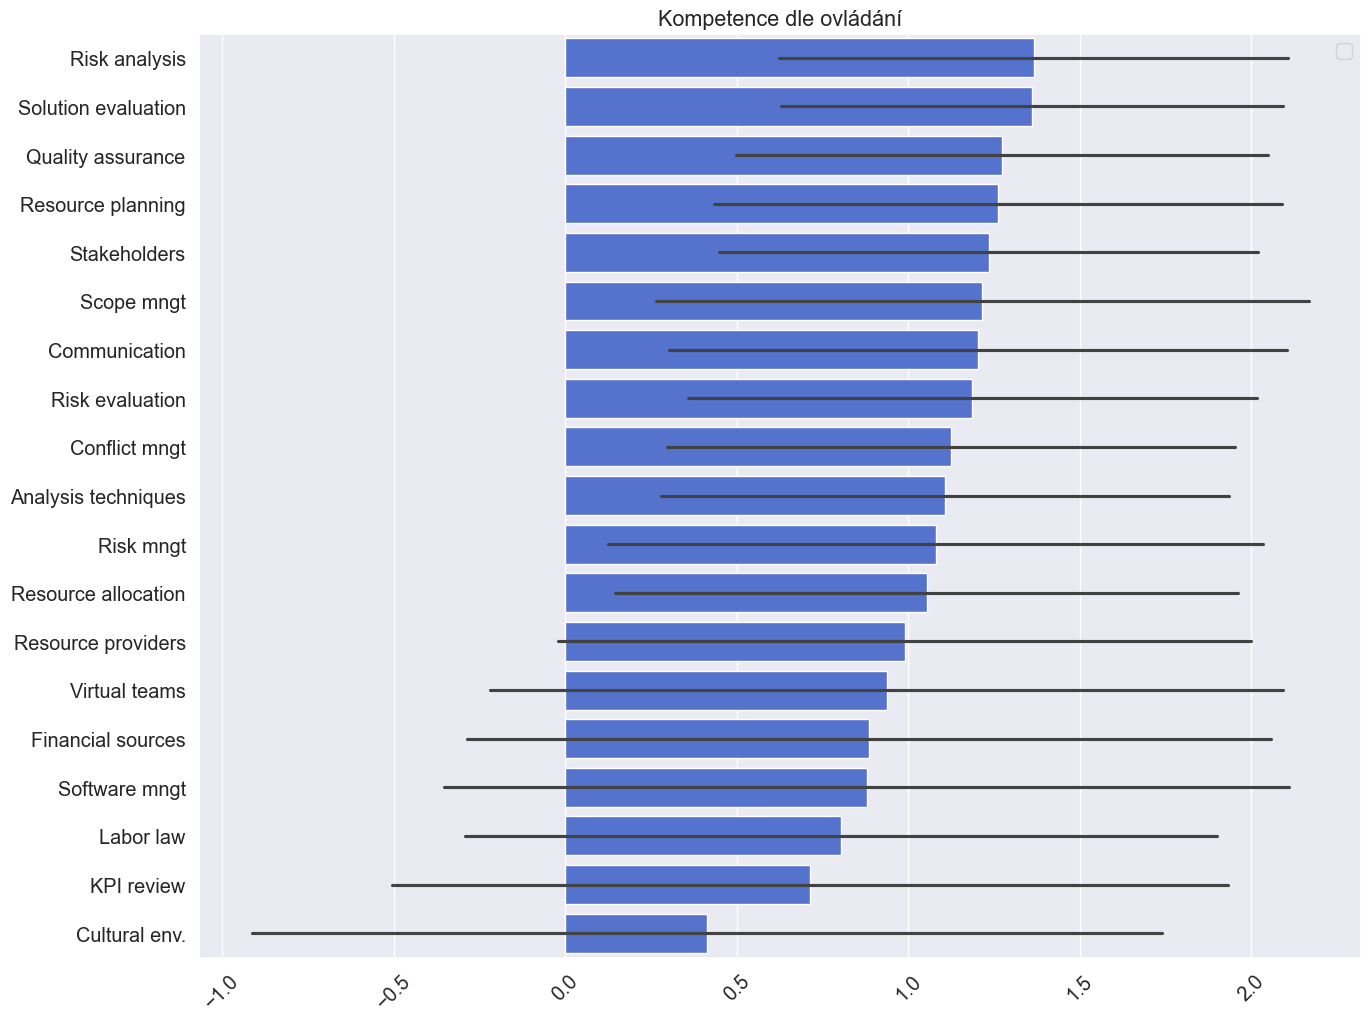

In [389]:
search_string = "x vůbec neovládám x zcela ovládám"

filtered_columns = [col for col in df.columns if search_string in col]
df_filtered_mastering = df[filtered_columns]
df_filtered_mastering = df_filtered_mastering.rename(columns=lambda x: x.replace(search_string, ""))
df_filtered_mastering = update_column_names(df_filtered_mastering)
plot_highest_and_lowest_avgs(df_filtered_mastering, 'Kompetence dle ovládání', 'Kompetence dle ovládání')

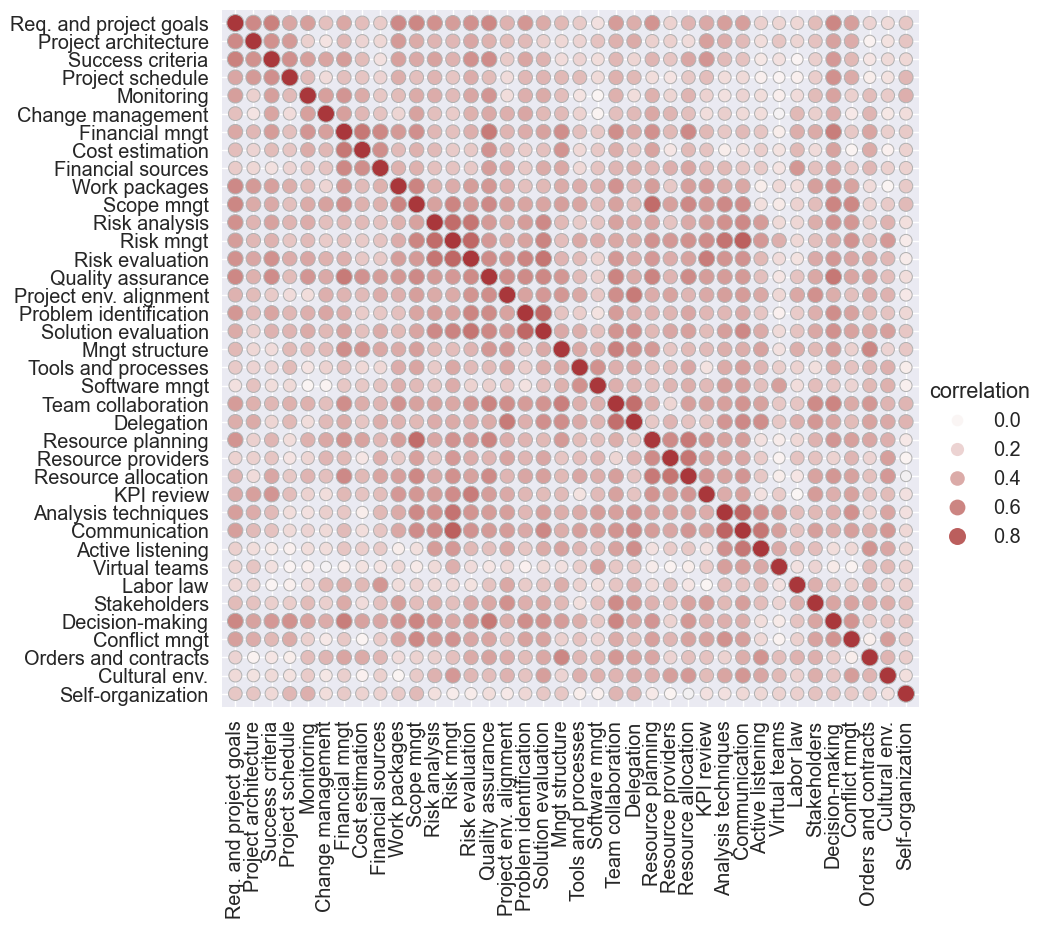

In [390]:
plot_correlation(df_filtered_mastering)

In [391]:
df_avg = pd.merge(df_avg, df_filtered_mastering.mean().to_frame(name="Ovládání"), left_index=True, right_index=True)

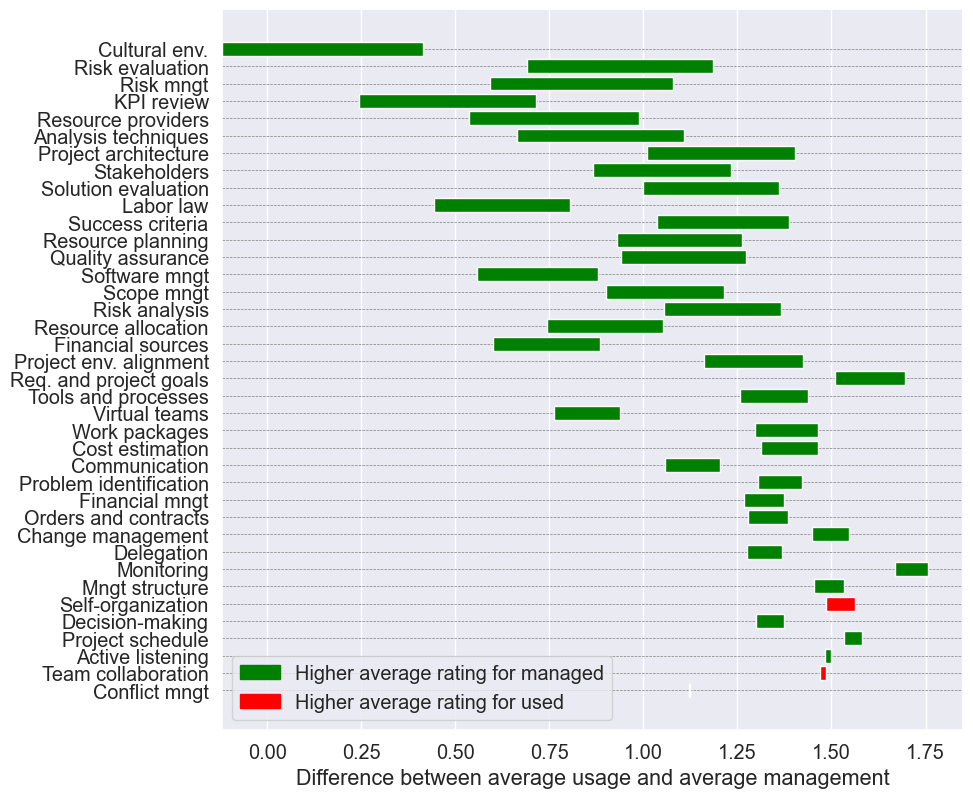

In [392]:
plot_diff_avg(df_avg, "Ovládání", "Využití", x_label="Difference between average usage and average management")

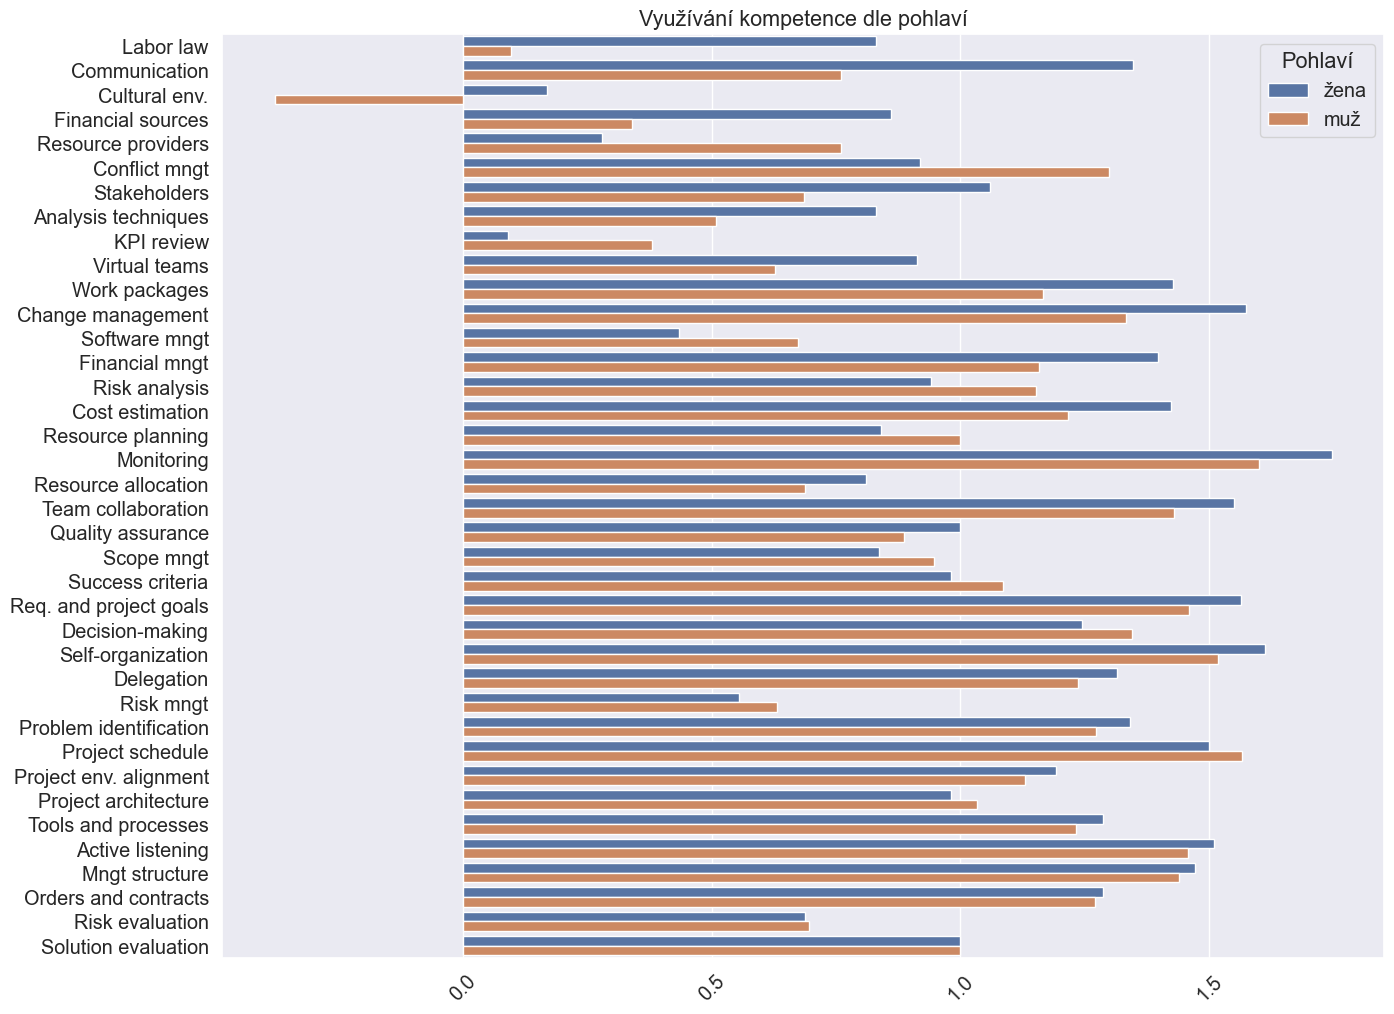

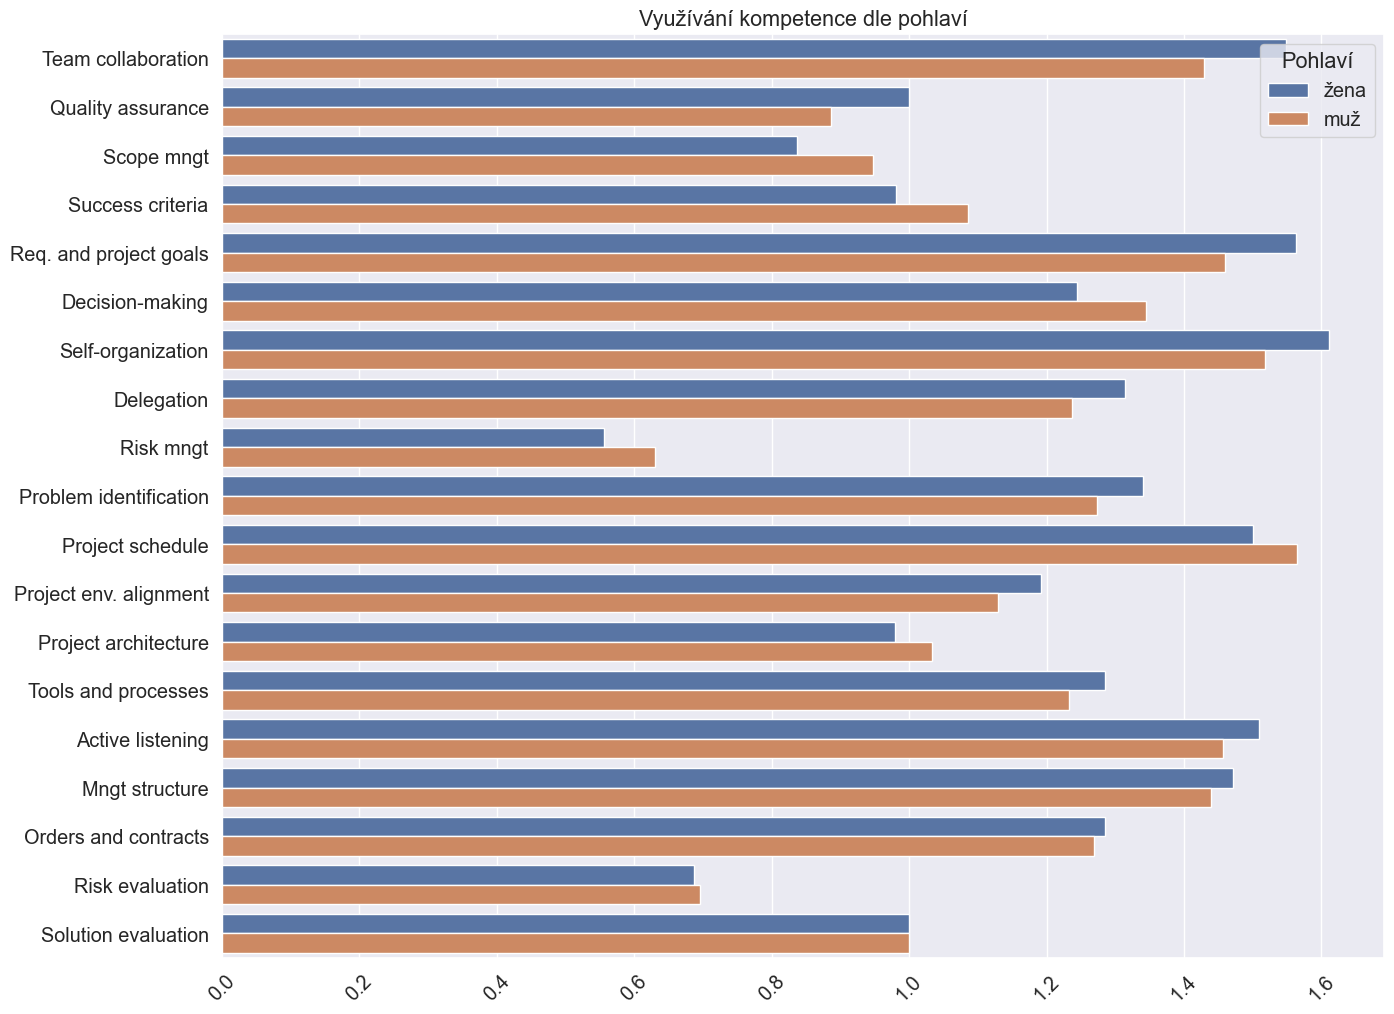

In [393]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Využívání kompetence dle pohlaví', "Jaké je vaše pohlaví?", "Pohlaví")

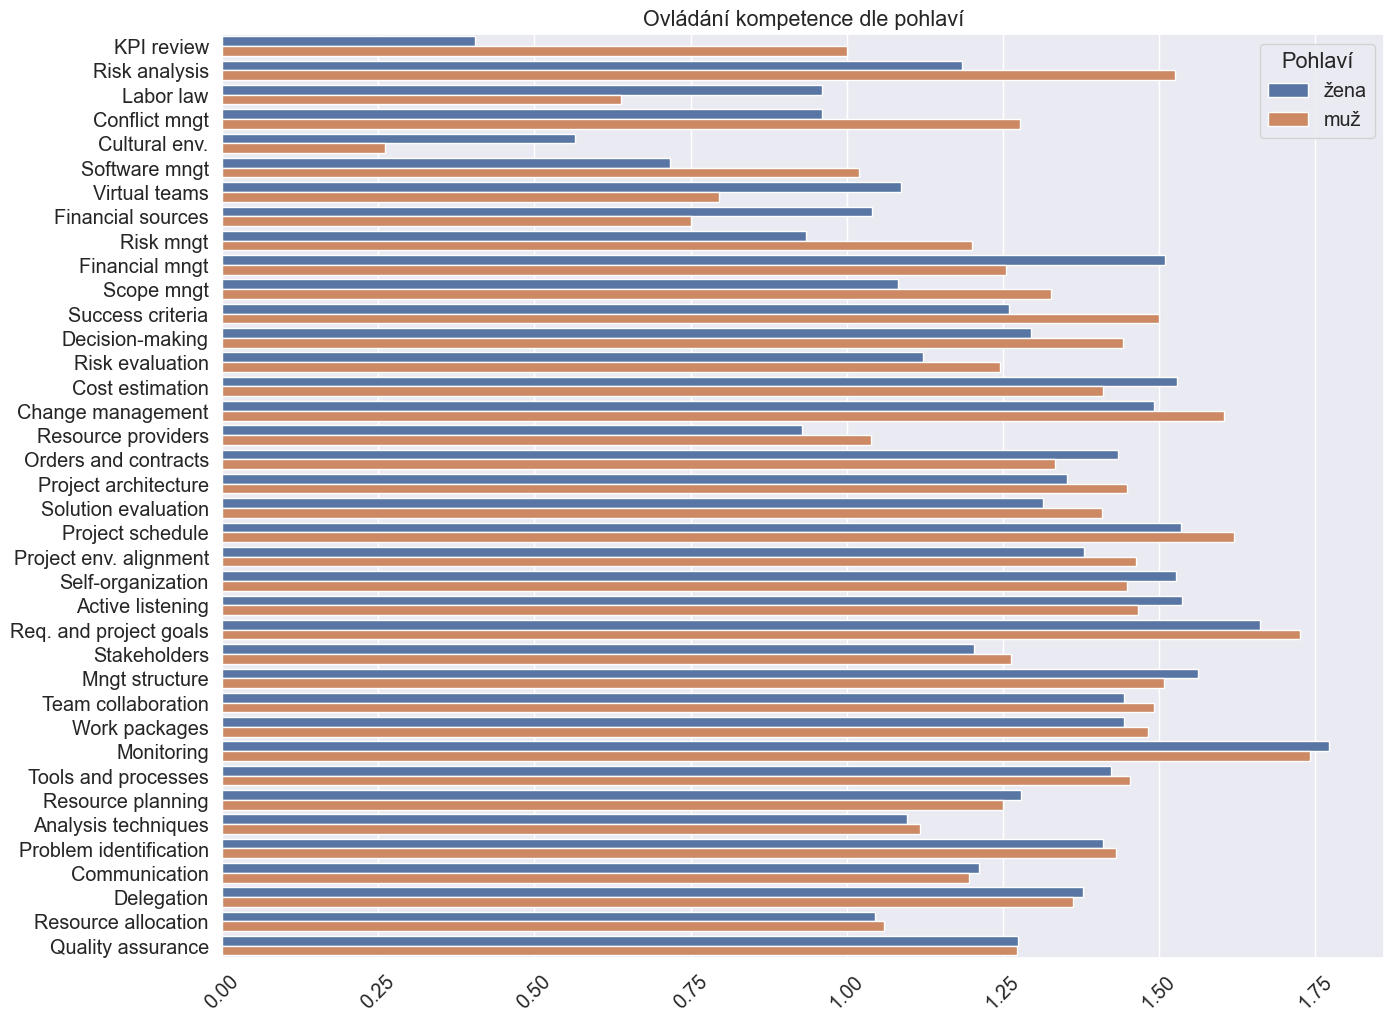

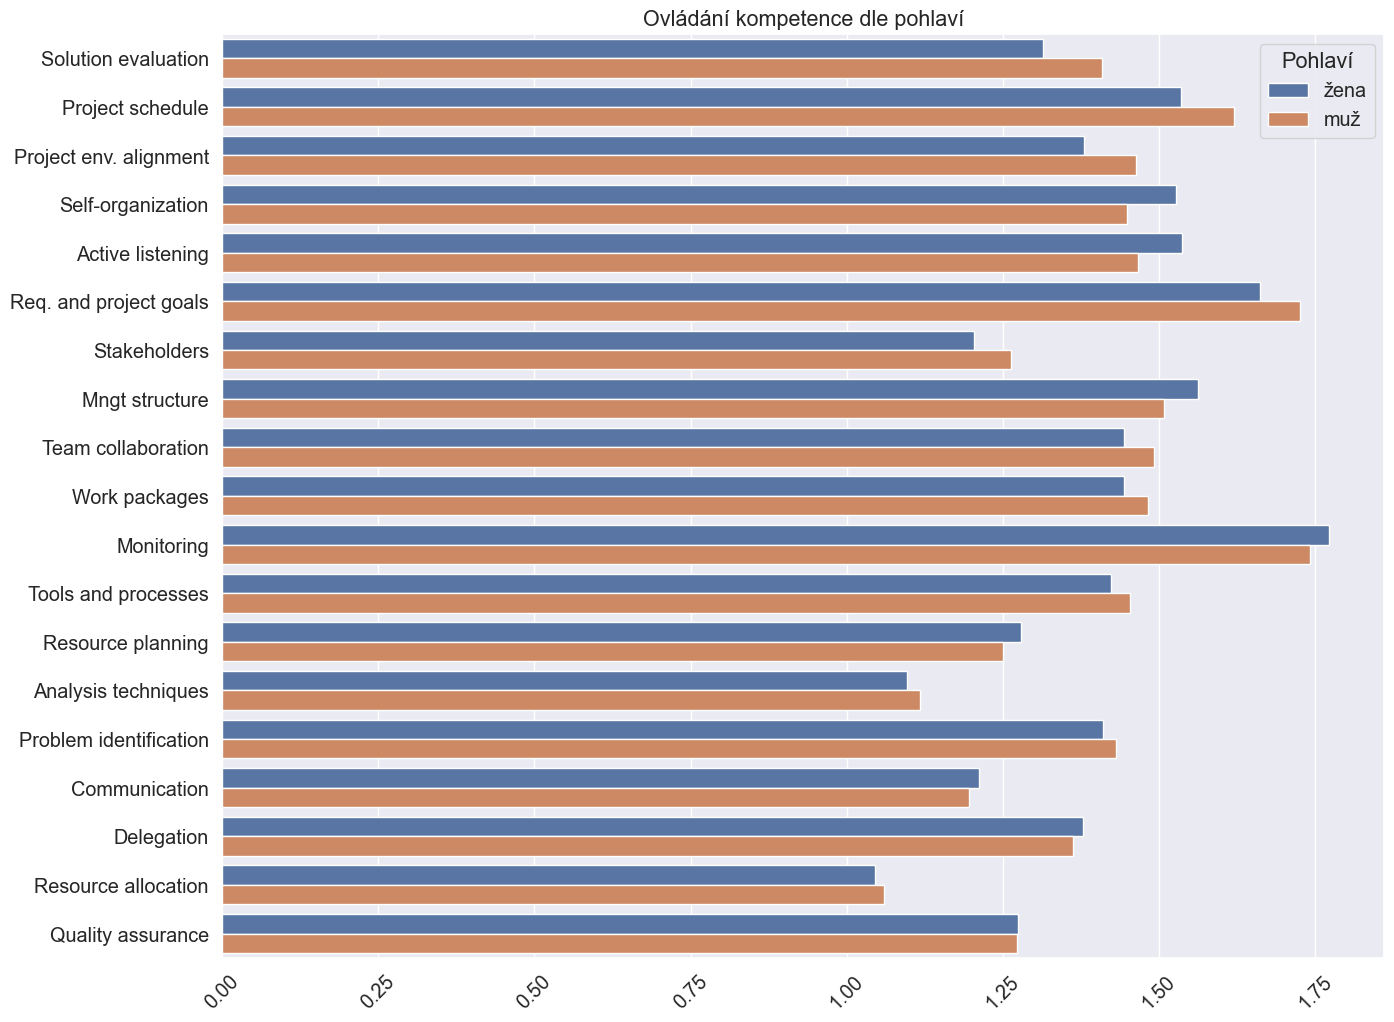

In [394]:
hue_plot_usage(df, "x vůbec neovládám x zcela ovládám", 'Ovládání kompetence dle pohlaví', "Jaké je vaše pohlaví?", "Pohlaví")

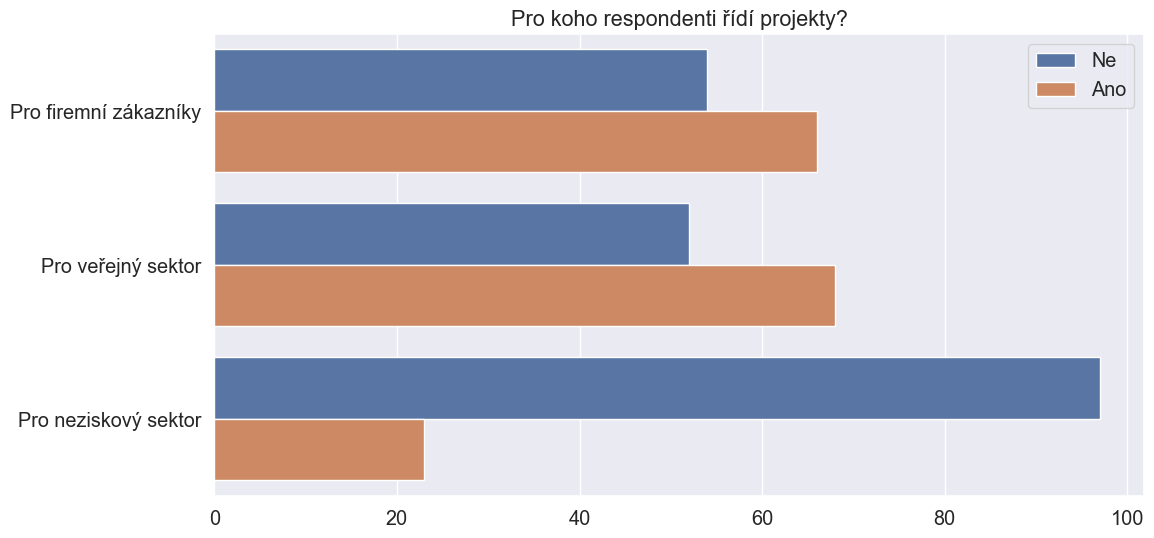

In [395]:
columns = [
    "Jaké typy projektu řídíte? x pro firemní zákazníky",
    "Jaké typy projektu řídíte? x pro veřejný sektor",
    "Jaké typy projektu řídíte? x pro neziskový sektor"
]

# Melt the DataFrame so we have 'Project Type' and 'Response' columns
melted_df = df[columns].melt(var_name='Project Type', value_name='Response')
melted_df["Project Type"] = melted_df["Project Type"].str.replace("Jaké typy projektu řídíte? x ", "").str.capitalize()

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=melted_df, y='Project Type', hue='Response')

# Enhance plot aesthetics
plt.title("Pro koho respondenti řídí projekty?")
plt.xlabel("")
plt.ylabel("")
plt.legend()

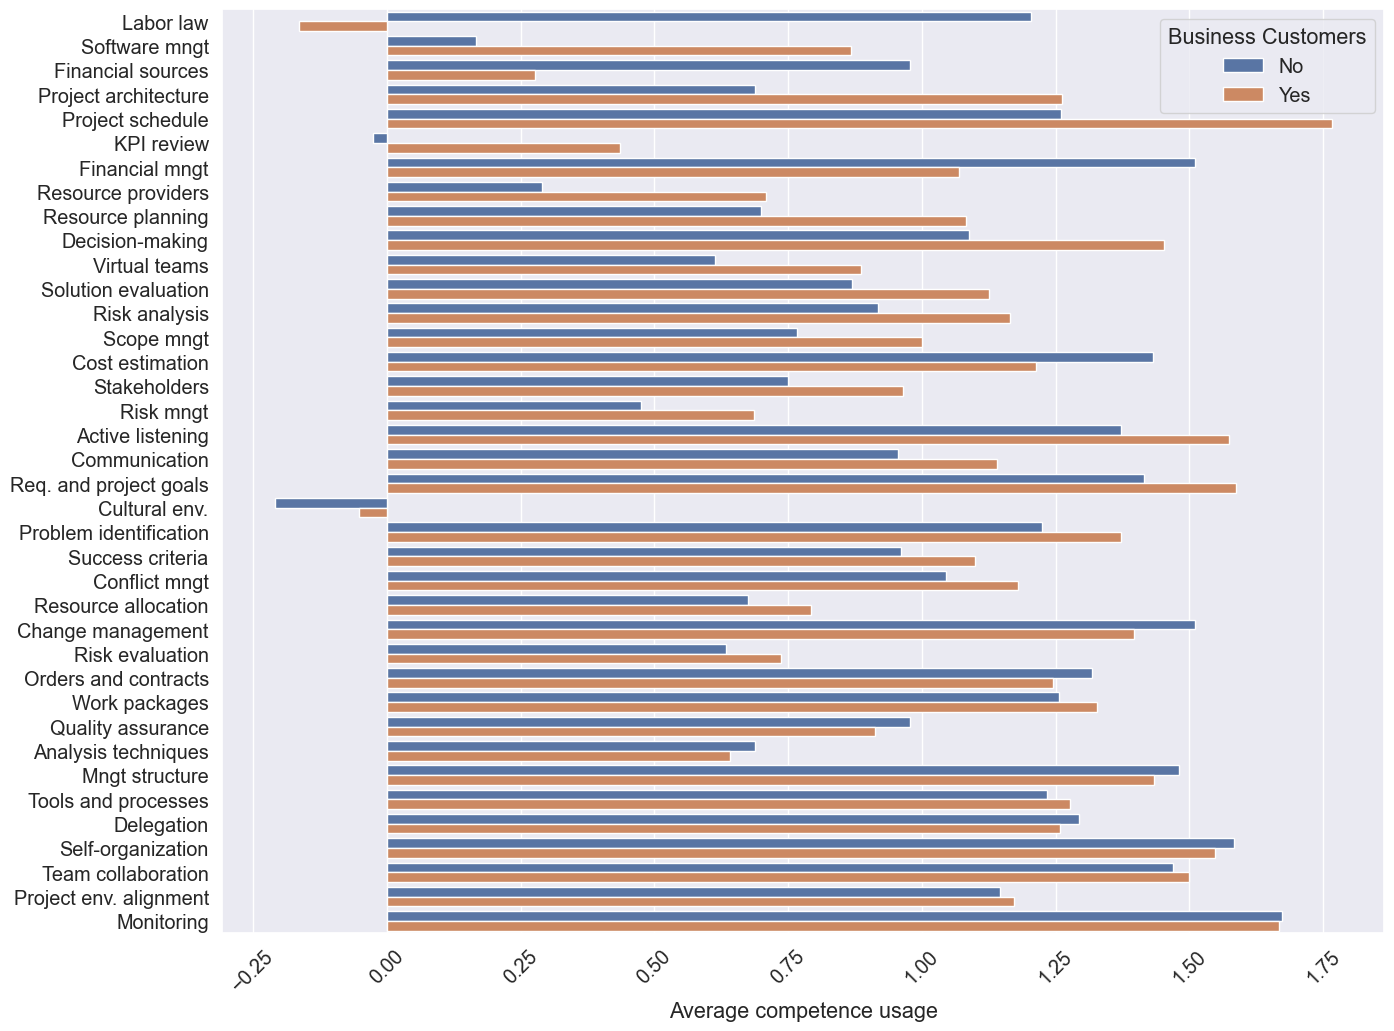

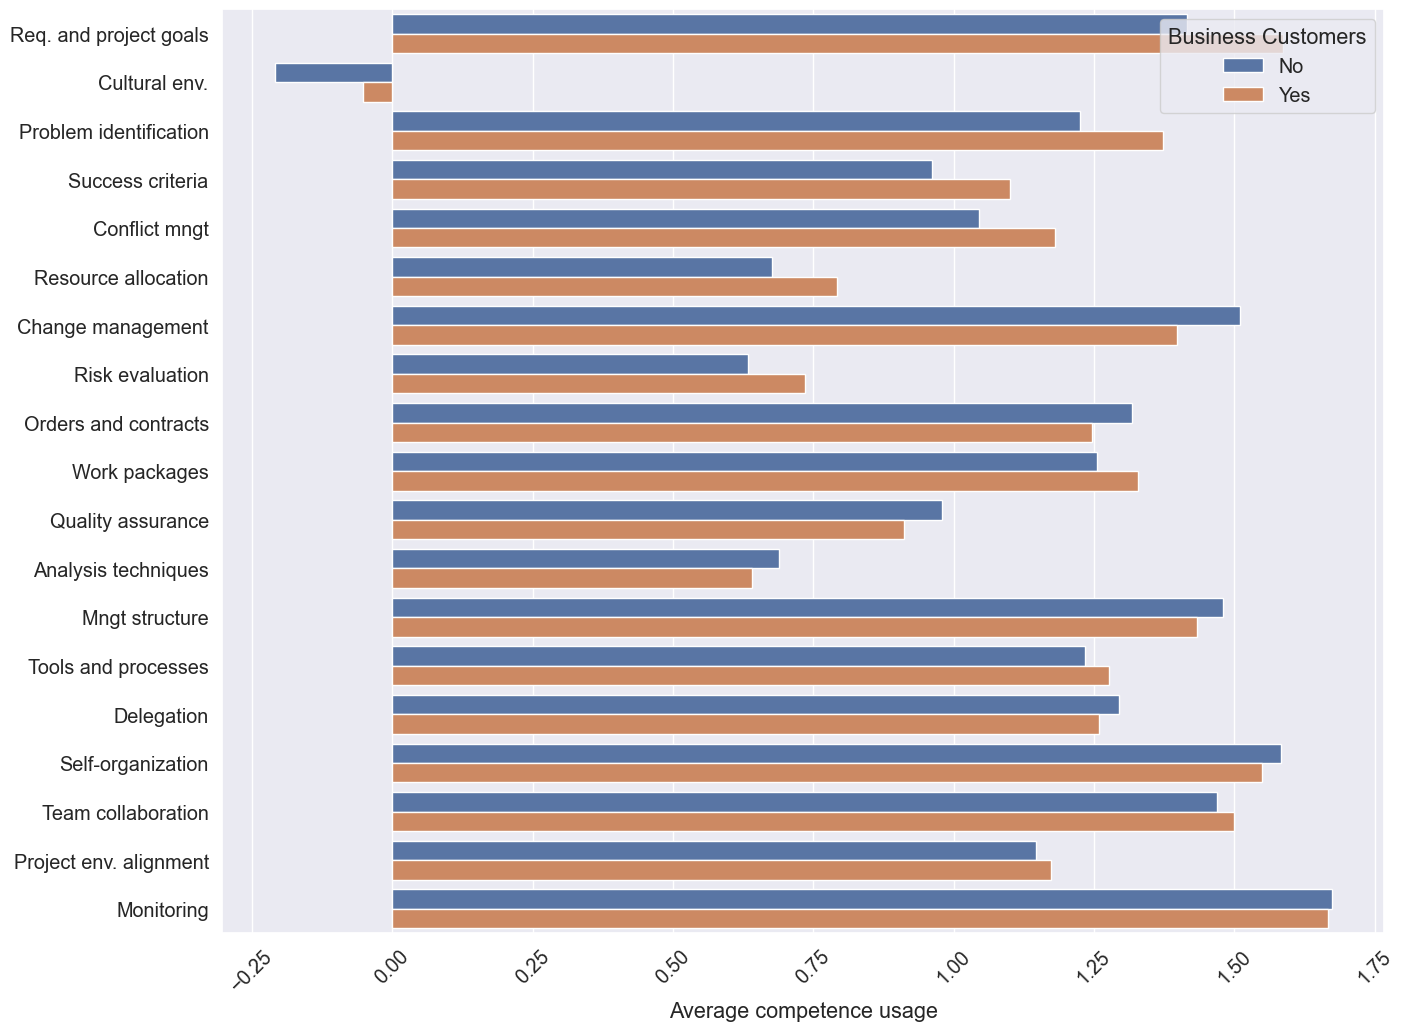

In [396]:
df = df.rename(columns={"Jaké typy projektu řídíte? x pro firemní zákazníky": "Business Customers"})
df["Business Customers"] = df["Business Customers"].map({"Ano": "Yes", "Ne": "No"})
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 
               None, "Business Customers", "Business Customers", x_label="Average competence usage")

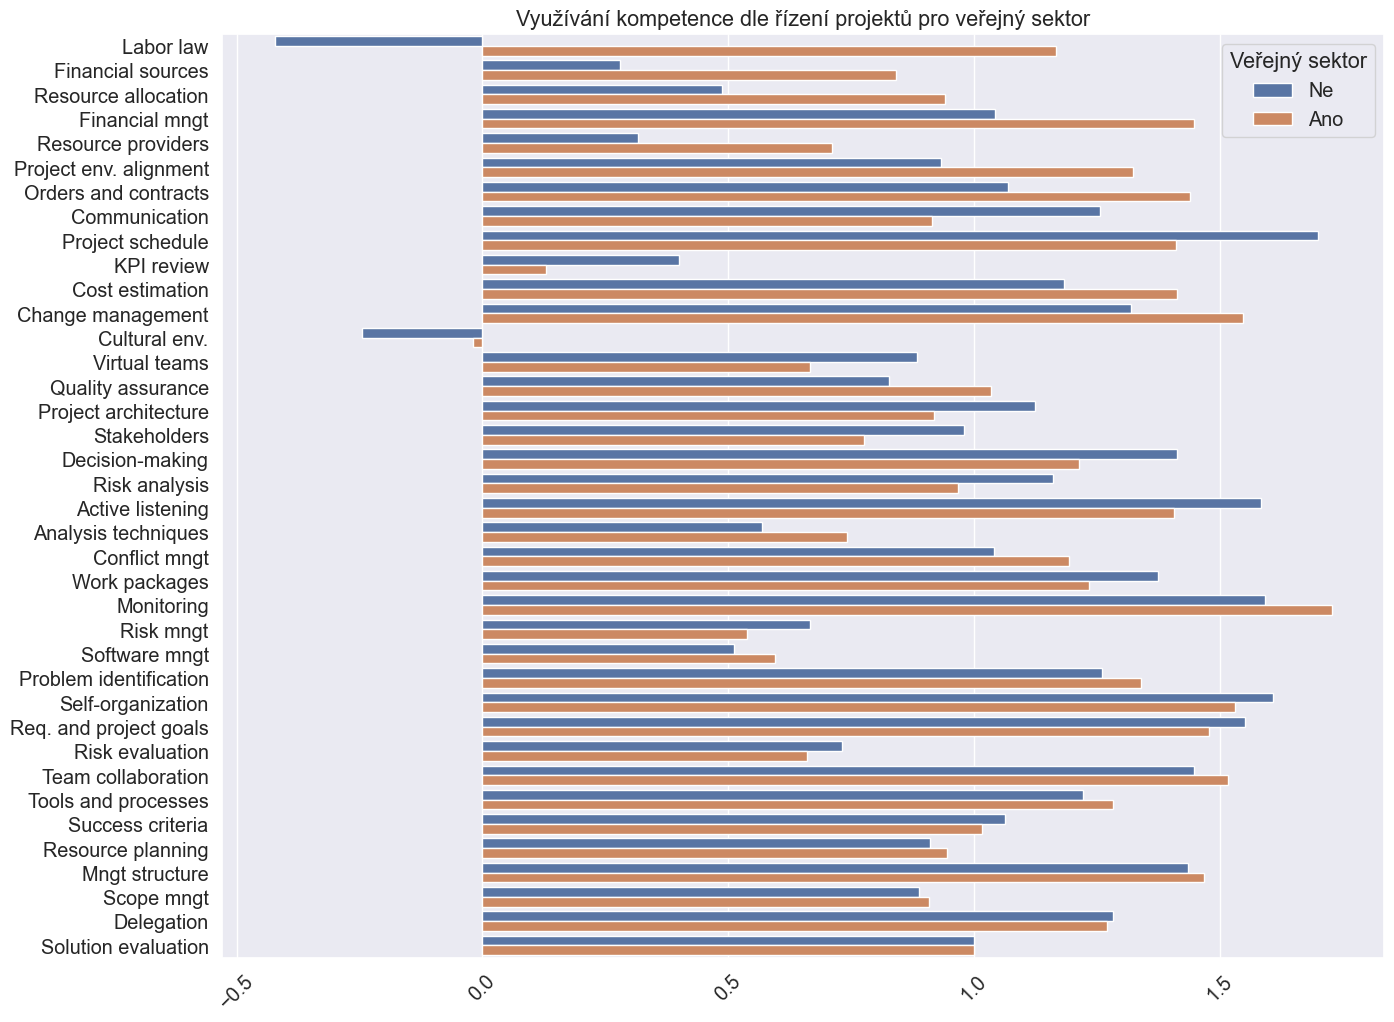

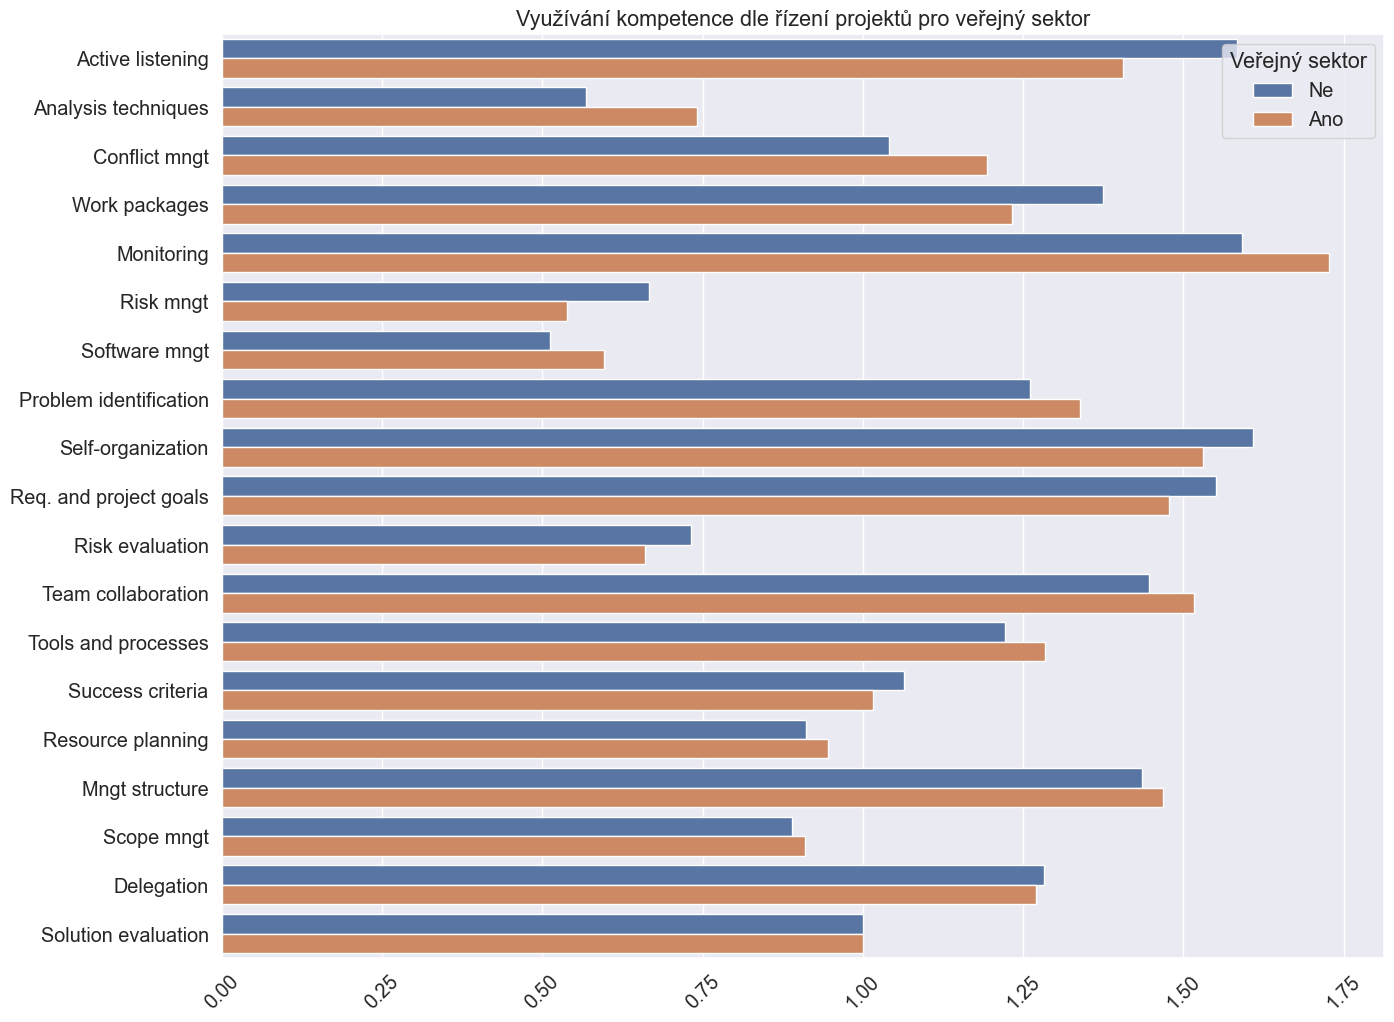

In [397]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Využívání kompetence dle řízení projektů pro veřejný sektor', 
               "Jaké typy projektu řídíte? x pro veřejný sektor", "Veřejný sektor")

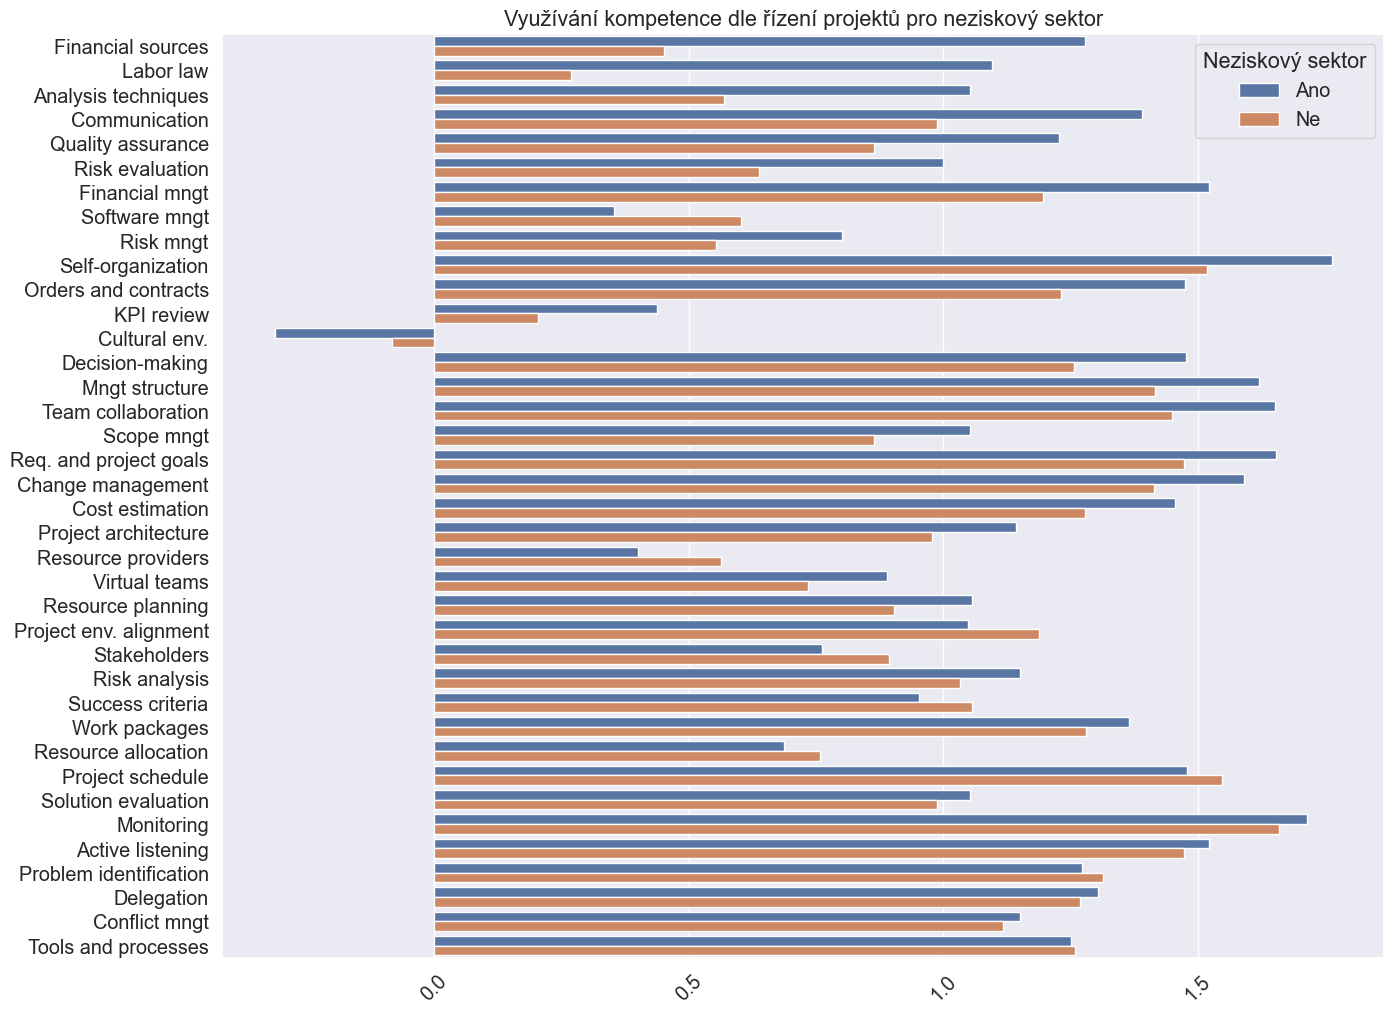

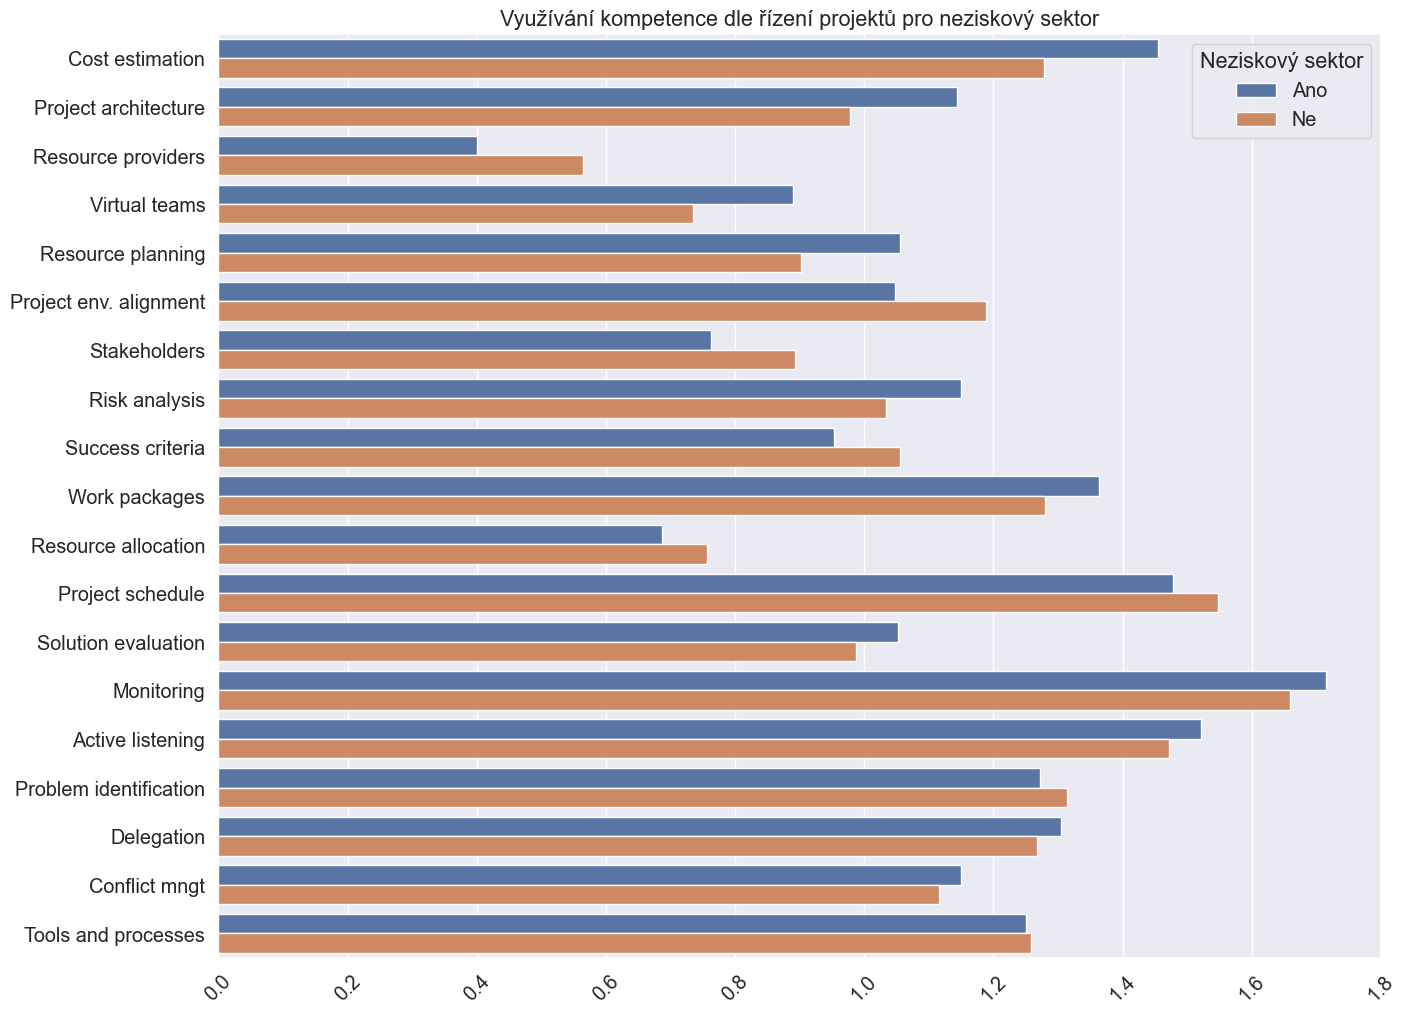

In [398]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Využívání kompetence dle řízení projektů pro neziskový sektor', 
               "Jaké typy projektu řídíte? x pro neziskový sektor", "Neziskový sektor")

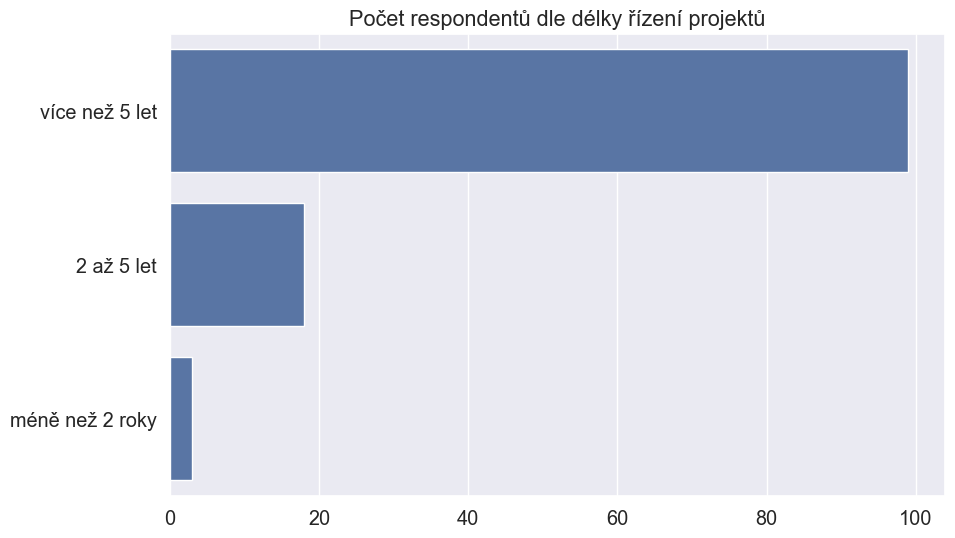

In [399]:
count_plot(df, "Počet respondentů dle délky řízení projektů", "Jak dlouho řídíte projekty?")

In [400]:
df_filtered_usage

Req. and project goals  Project architecture  Success criteria  \
0                       2.0                   NaN               2.0   
1                       2.0                   2.0               2.0   
2                       2.0                   2.0               2.0   
3                       2.0                   2.0               2.0   
4                       2.0                  -1.0              -2.0   
..                      ...                   ...               ...   
115                     1.0                   1.0               2.0   
116                     2.0                  -1.0               1.0   
117                     1.0                  -1.0              -2.0   
118                     2.0                   1.0               1.0   
119                     NaN                   NaN               1.0   

     Project schedule  Monitoring  Change management  Financial mngt  \
0                 2.0         2.0                2.0             2.0   
1                 2.0         2.0                2.0             2.0   
2                 2.0         2.0                2.0             2.0   
3                 2.0         2.0                2.0             2.0   
4                 2.0         2.0                1.0             2.0   
..                ...         ...                ...             ...   
115               2.0         2.0                1.0             1.0   
116               1.0         2.0                2.0             2.0   
117              -1.0         2.0                2.0             2.0   
118               2.0         2.0                2.0             1.0   
119               2.0         2.0                2.0             2.0   

     Cost estimation  Financial sources  Work packages  ...  Communication  \
0                2.0                2.0            2.0  ...            2.0   
1                2.0                2.0            2.0  ...            2.0   
2                2.0                1.0            2.0  ...            1.0   
3                2.0                2.0            2.0  ...            2.0   
4                2.0                2.0            1.0  ...            1.0   
..               ...                ...            ...  ...            ...   
115              1.0                1.0            1.0  ...            2.0   
116              2.0                2.0            2.0  ...            2.0   
117              2.0                2.0            1.0  ...            2.0   
118              2.0                NaN            2.0  ...            2.0   
119              2.0                NaN            2.0  ...            1.0   

     Active listening  Virtual teams  Labor law  Stakeholders  \
0                 2.0            2.0        2.0           2.0   
1                 1.0            NaN        2.0           NaN   
2                 2.0            1.0       -1.0          -1.0   
3                 1.0            NaN        NaN          -1.0   
4                 1.0           -2.0        2.0          -2.0   
..                ...            ...        ...           ...   
115               2.0            NaN        NaN           1.0   
116               2.0            2.0        2.0           2.0   
117               2.0           -1.0        2.0           1.0   
118               NaN           -1.0        1.0           2.0   
119              -1.0            1.0        2.0           1.0   

     Decision-making  Conflict mngt  Orders and contracts  Cultural env.  \
0                2.0            1.0                   2.0            NaN   
1                2.0            2.0                   2.0            2.0   
2               -1.0            1.0                   2.0           -2.0   
3                NaN            1.0                   1.0            NaN   
4                2.0            1.0                   2.0           -1.0   
..               ...            ...                   ...            ...   
115              1.0            NaN  

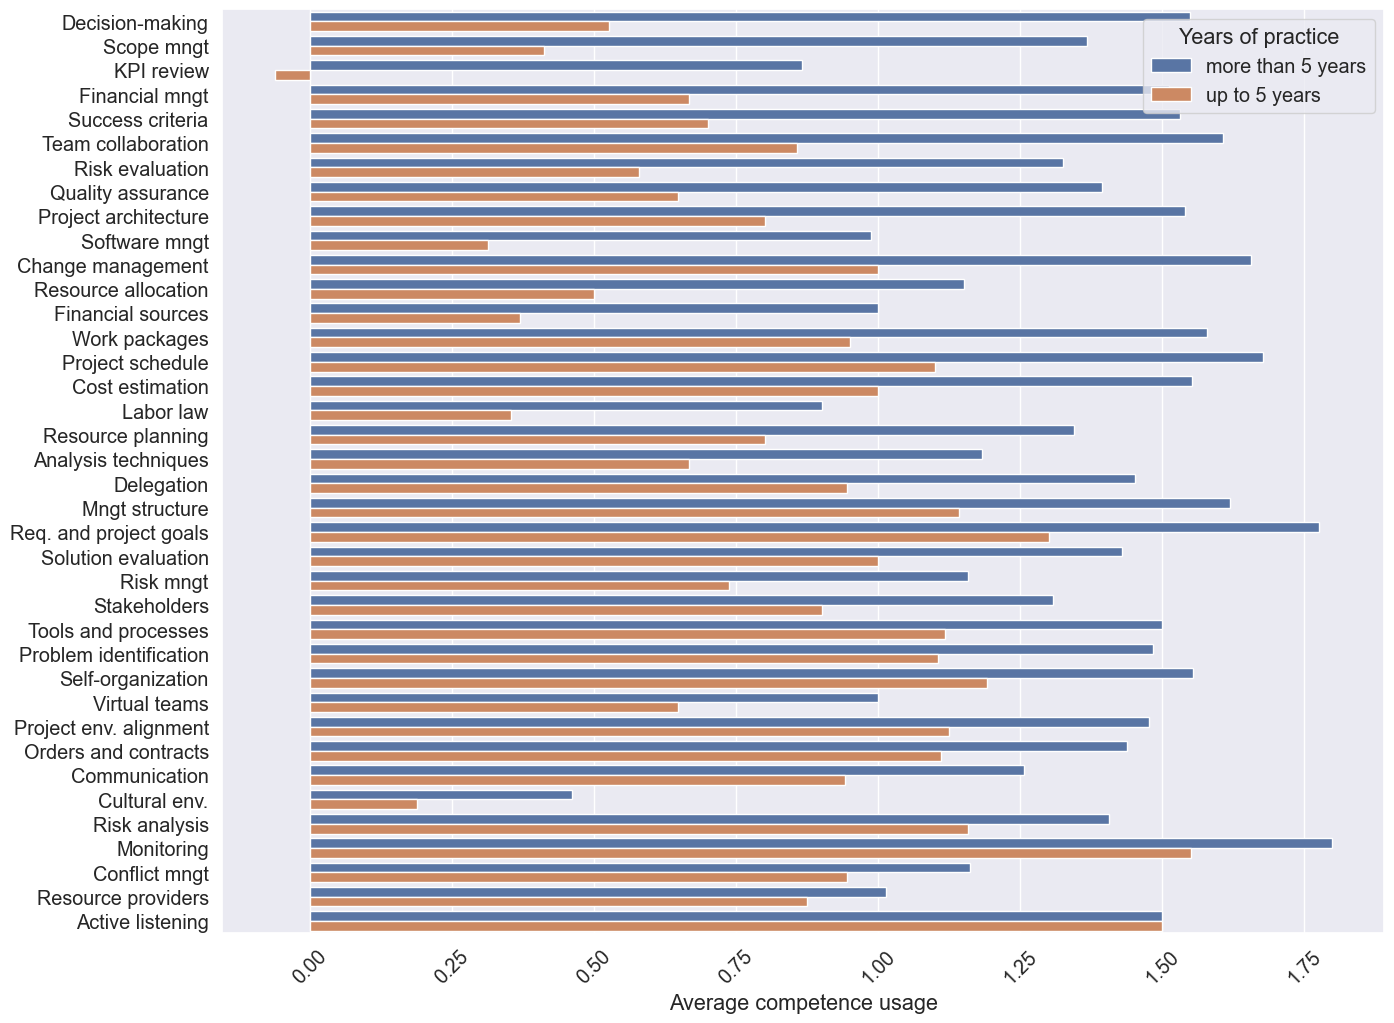

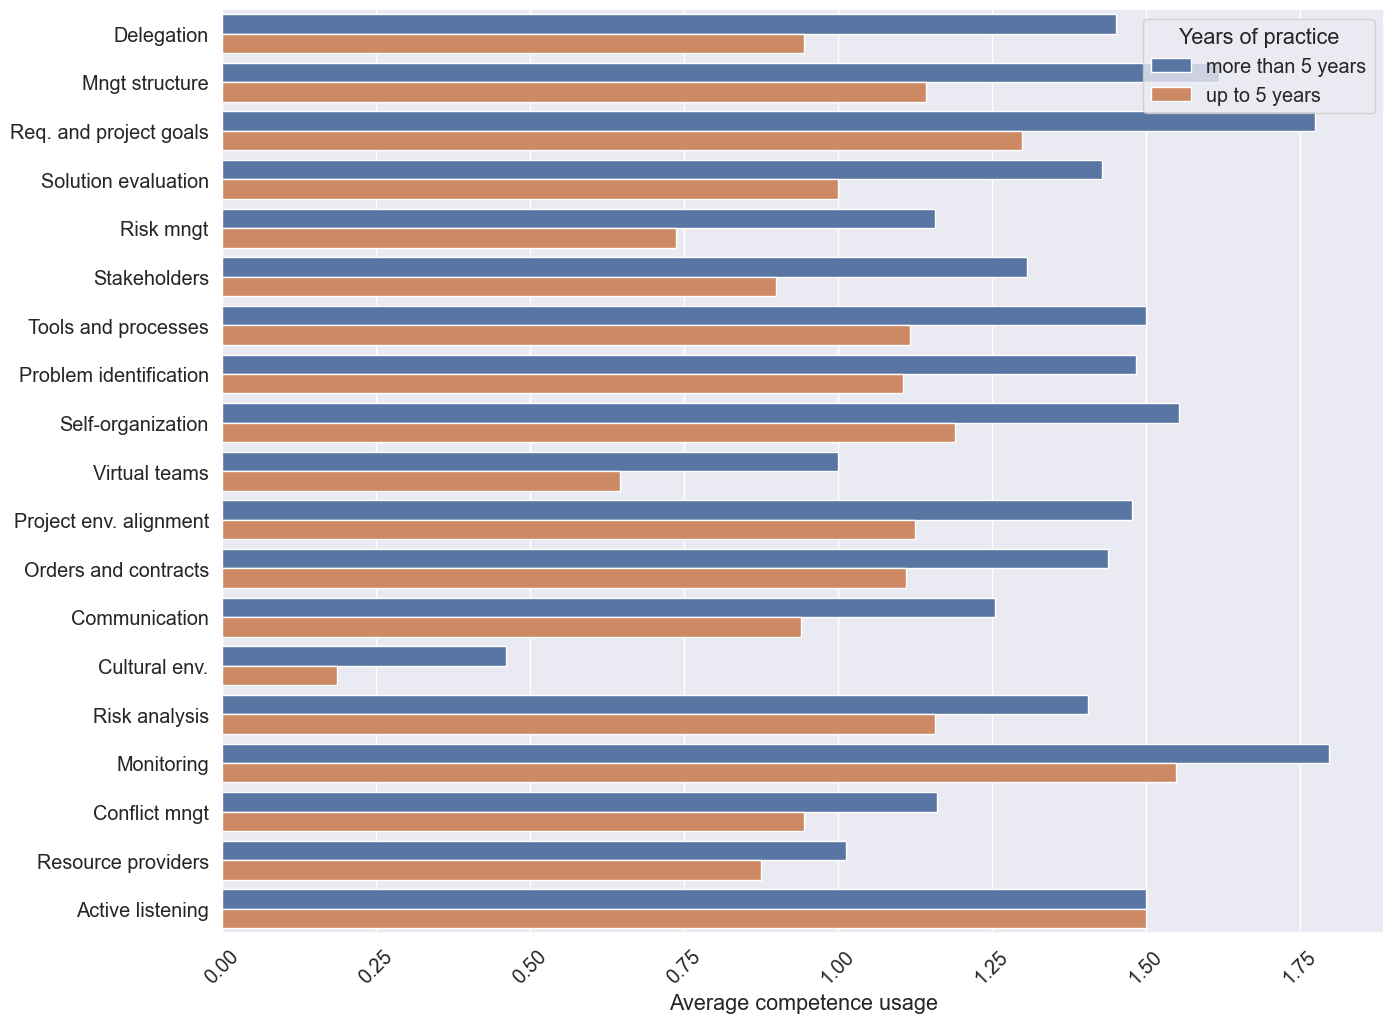

In [401]:
df["Jak dlouho řídíte projekty?"] = df["Jak dlouho řídíte projekty?"].str.replace("méně než 2 roky", "up to 5 years")
df["Jak dlouho řídíte projekty?"] = df["Jak dlouho řídíte projekty?"].str.replace("2 až 5 let", "up to 5 years")
df["Jak dlouho řídíte projekty?"] = df["Jak dlouho řídíte projekty?"].str.replace("více než 5 let", "more than 5 years")
hue_plot_usage(df, "x vůbec neovládám x zcela ovládám", None, "Jak dlouho řídíte projekty?", "Years of practice", x_label="Average competence usage")

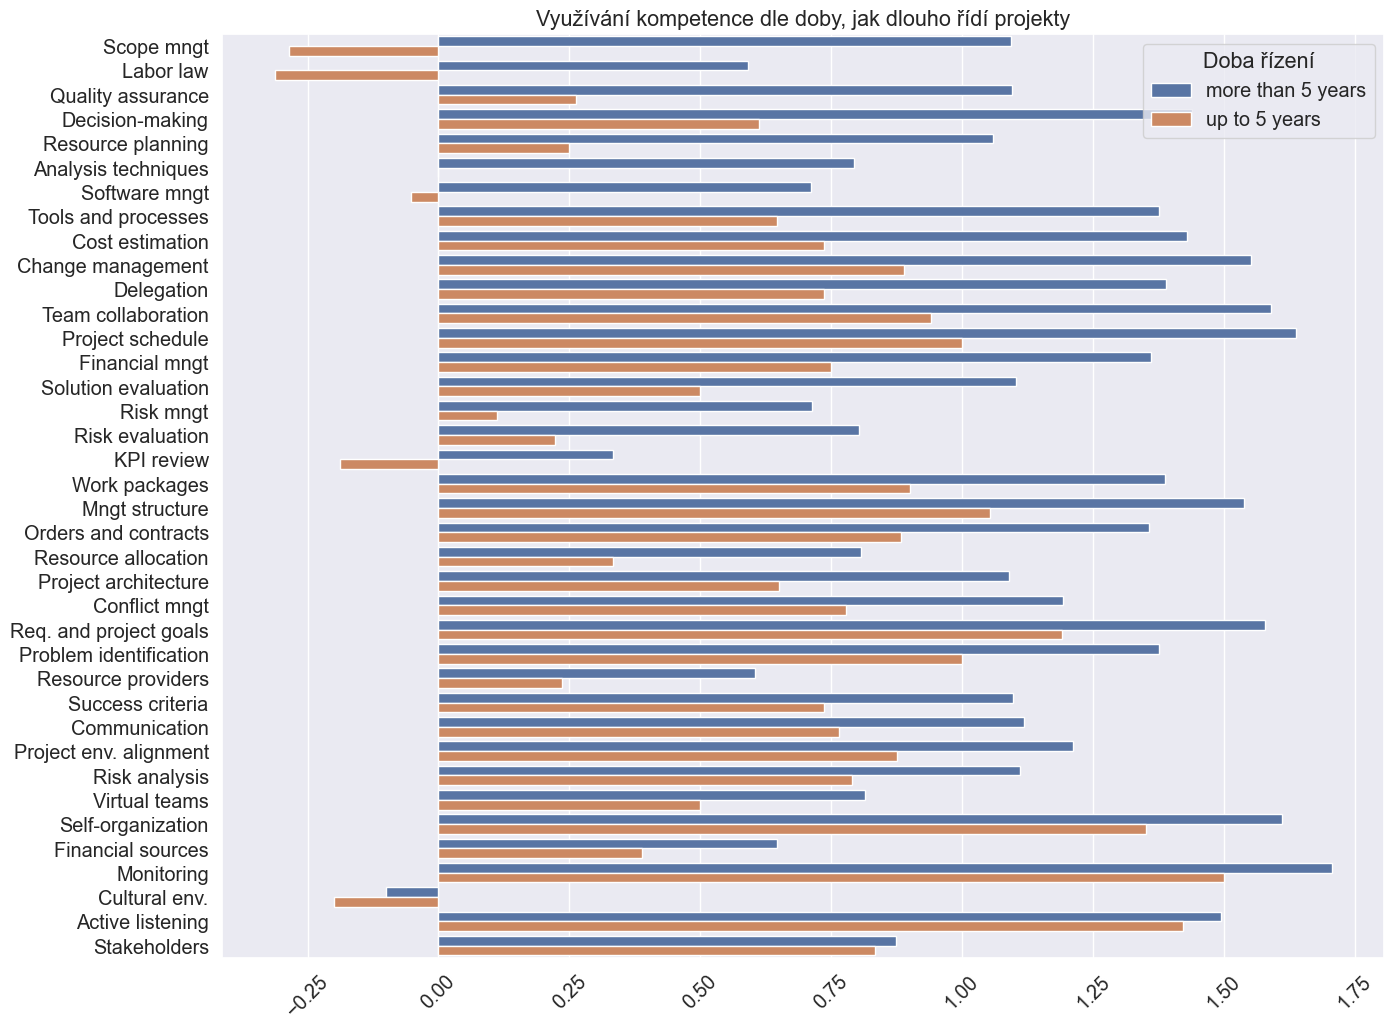

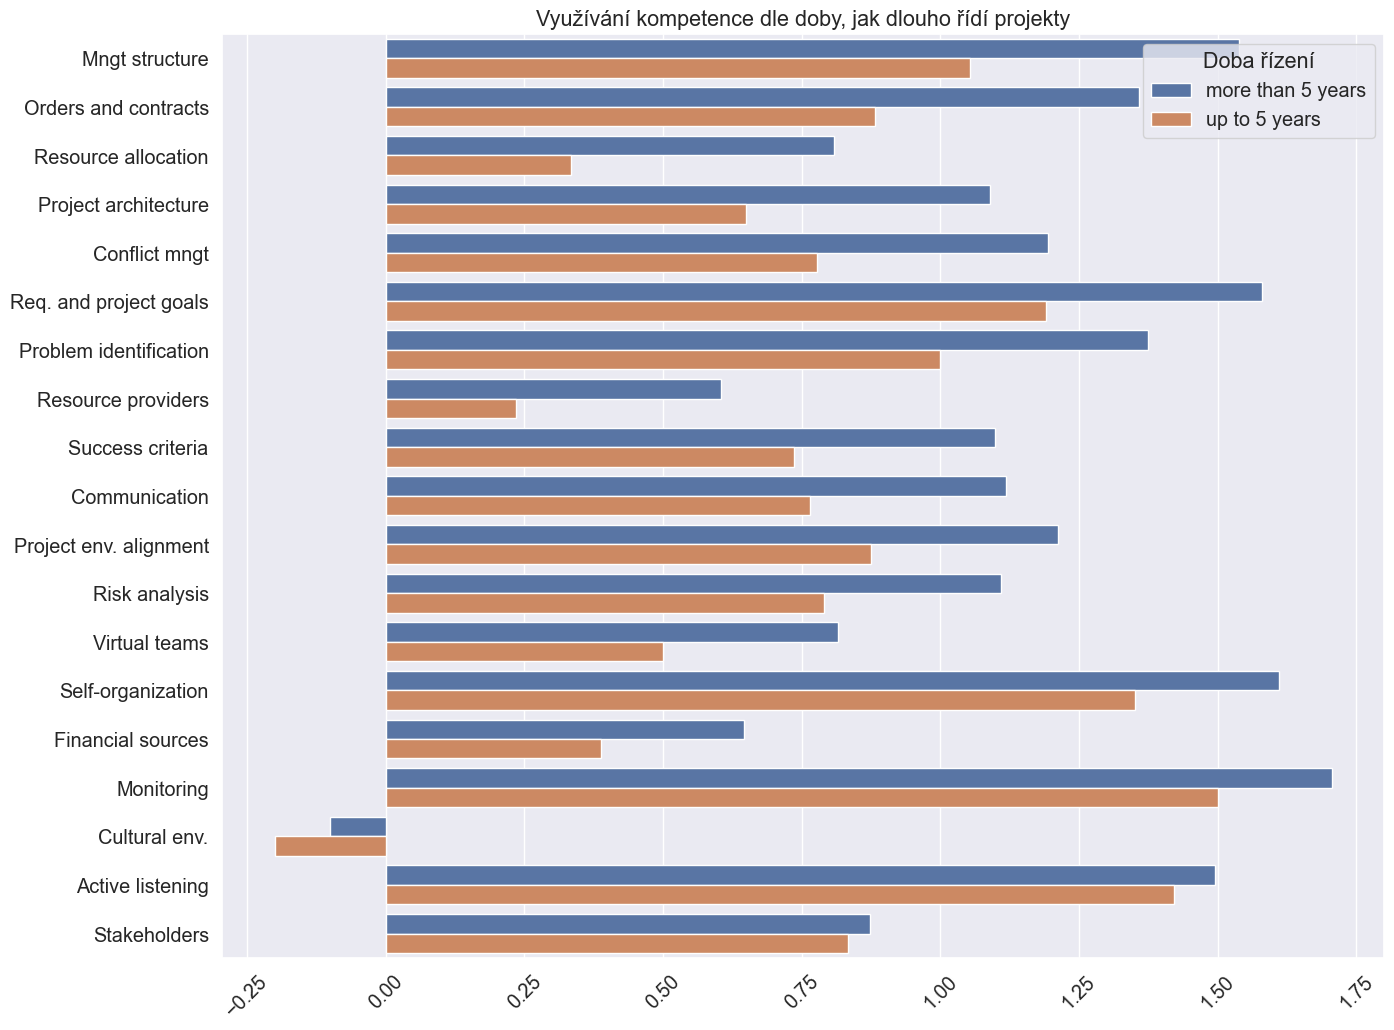

In [402]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Využívání kompetence dle doby, jak dlouho řídí projekty', "Jak dlouho řídíte projekty?", "Doba řízení")

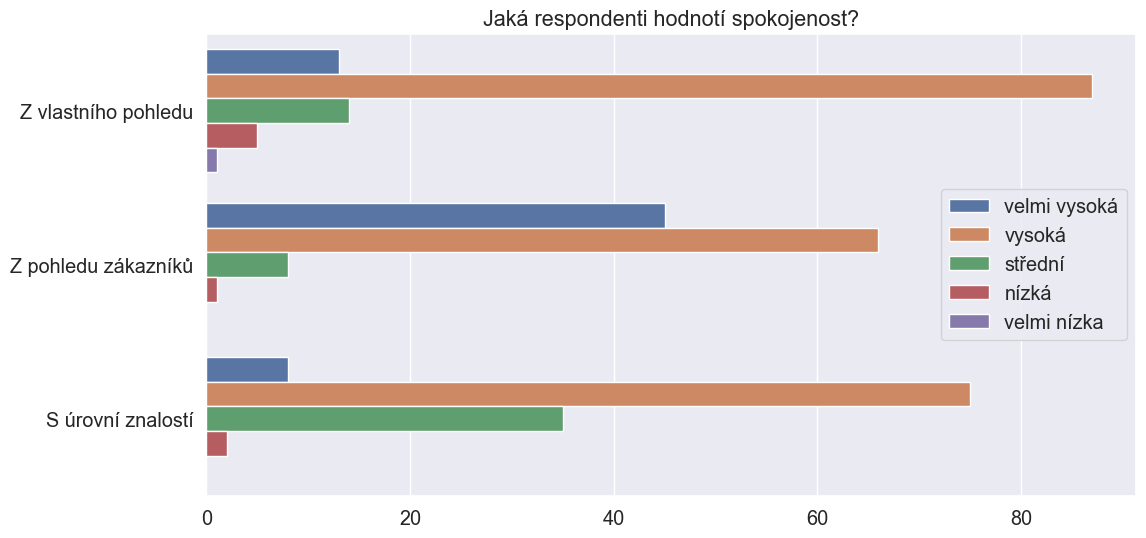

In [403]:
columns = [
    "S tím, jak aktuálně vedete projekty, jste",
    "S výsledky projektů, které vedu, jsou zákazníci",
    "Úroveň mých znalostí projektového řízení považuji celkově za"
]

# Melt the DataFrame so we have 'Project Type' and 'Response' columns
melted_df = df[columns].melt(var_name='Satisfaction', value_name='Response')

response_mapping = {
    'velmi spokojen(a)': 'velmi vysoká',
    'spíše spokojen(a)': 'vysoká',
    'ani spokojen(a), ani nespokojen(a)': 'střední',
    'spíše nespokojen(a)': 'nízká',
    'velmi nespokojen(a)': 'velmi nízka',
    'velmi spokojeni': 'velmi vysoká',
    'spíše spokojeni': 'vysoká',
    'ani spokojeni, ani nespokojeni': 'střední',
    'spíše nespokojeni': 'nízká',
    'průměrnou': 'střední',
    'vynikající': 'velmi vysoká',
    'nadprůměrnou': 'vysoká',
    'podprůměrnou': 'nízká'
}

satisfaction_mapping = {
    "S tím, jak aktuálně vedete projekty, jste": "Z vlastního pohledu",
    "S výsledky projektů, které vedu, jsou zákazníci": "Z pohledu zákazníků",
    "Úroveň mých znalostí projektového řízení považuji celkově za": "S úrovní znalostí",
}
melted_df['Response'] = melted_df['Response'].map(response_mapping)
melted_df['Satisfaction'] = melted_df['Satisfaction'].map(satisfaction_mapping)
response_order = ['velmi vysoká', 'vysoká', 'střední', 'nízká', 'velmi nízka']

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=melted_df, y='Satisfaction', hue='Response', hue_order=response_order)

# Enhance plot aesthetics
plt.title("Jaká respondenti hodnotí spokojenost?")
plt.xlabel("")
plt.ylabel("")
plt.legend()

In [404]:
df["S výsledky projektů, které vedu, jsou zákazníci"] = df["S výsledky projektů, které vedu, jsou zákazníci"].str.replace("spíše nespokojeni", "ani spokojeni, ani nespokojeni")
df["Jak dlouho řídíte projekty?"] = df["Jak dlouho řídíte projekty?"].str.replace("2 až 5 let", "méně než 5 let")

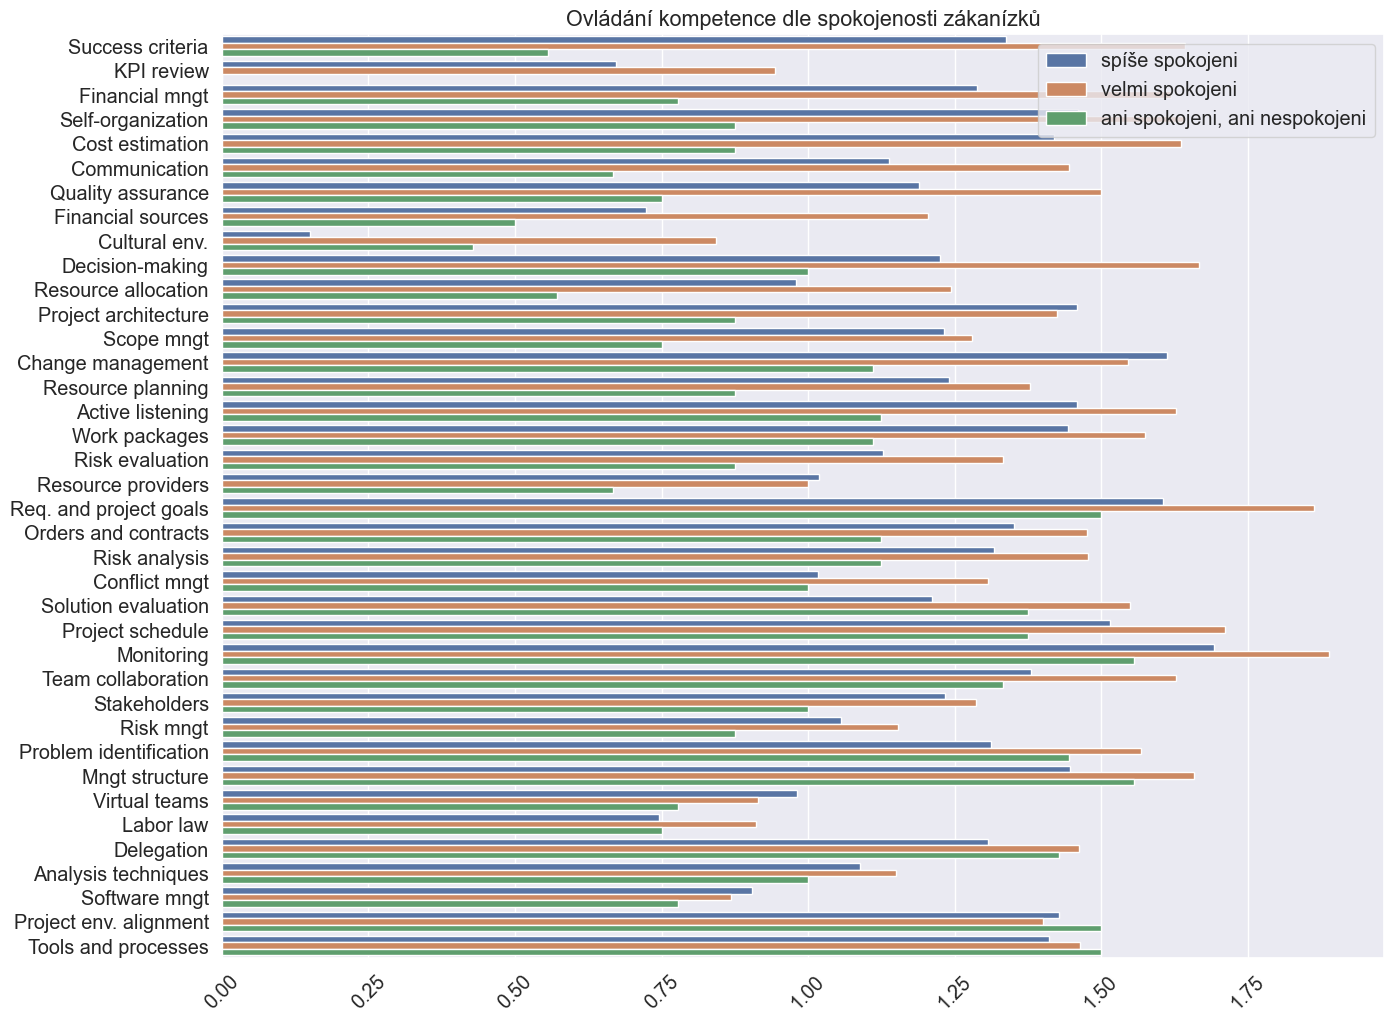

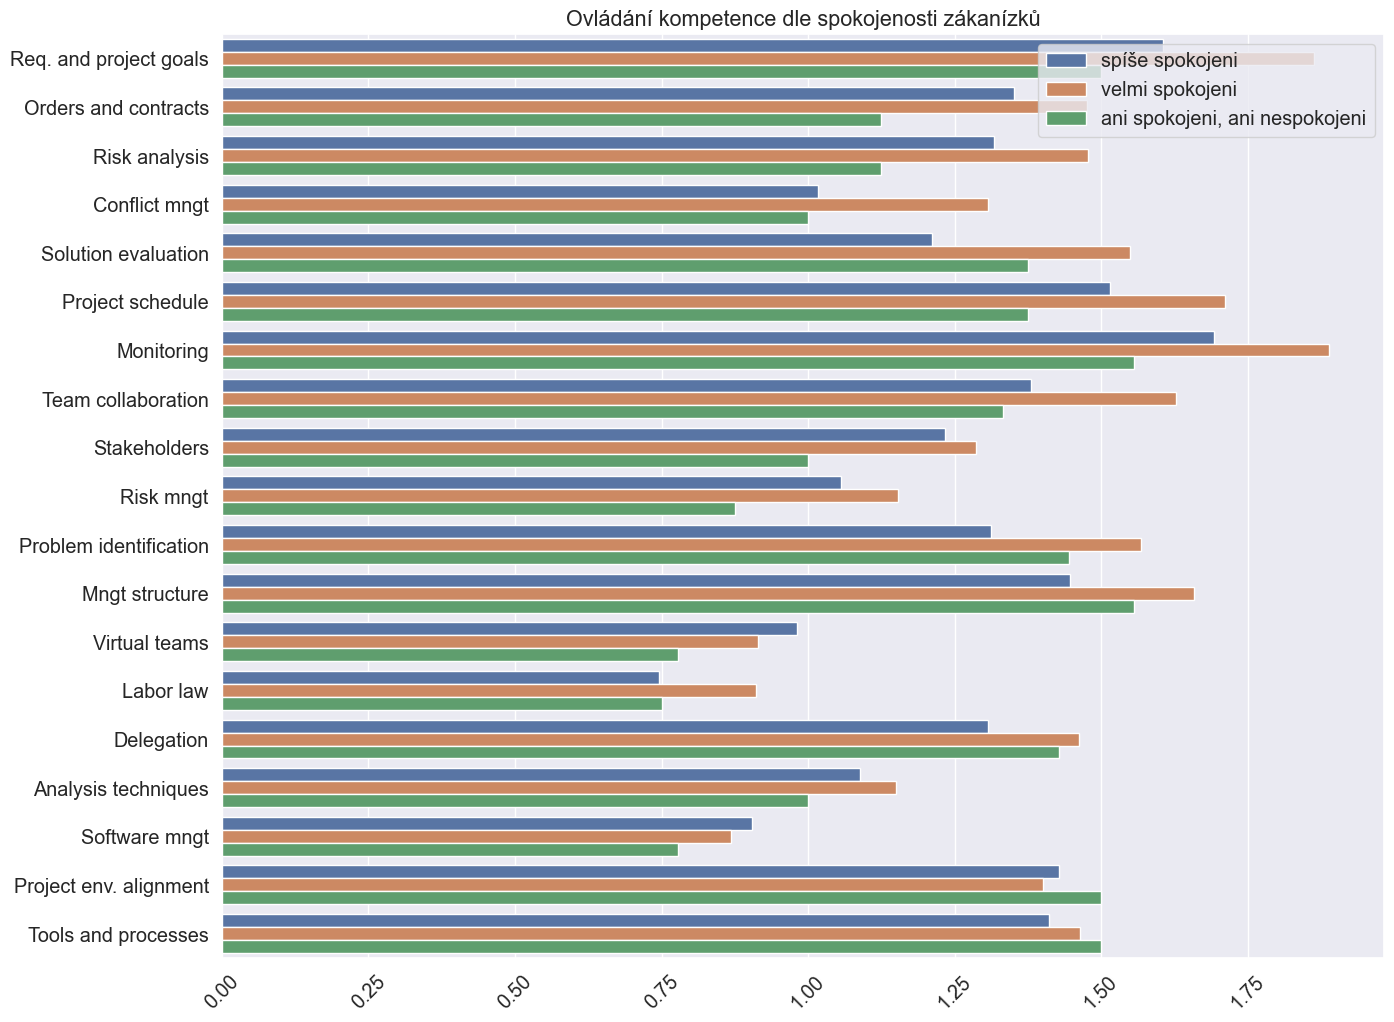

In [405]:
hue_plot_usage(df, "x vůbec neovládám x zcela ovládám", 'Ovládání kompetence dle spokojenosti zákanízků', 
               "S výsledky projektů, které vedu, jsou zákazníci", "")

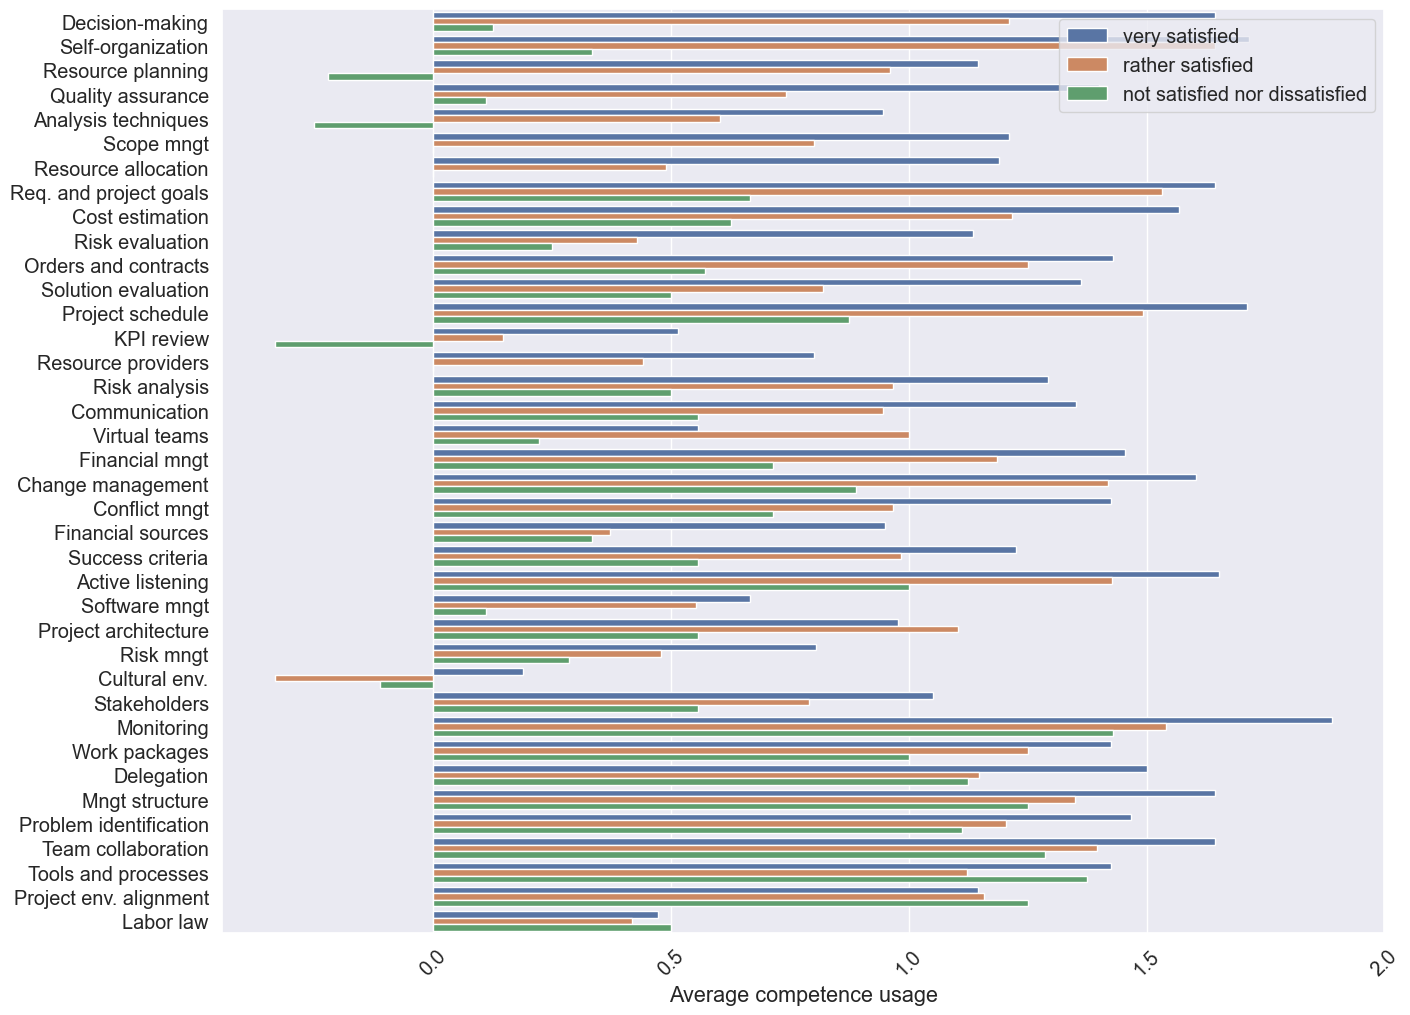

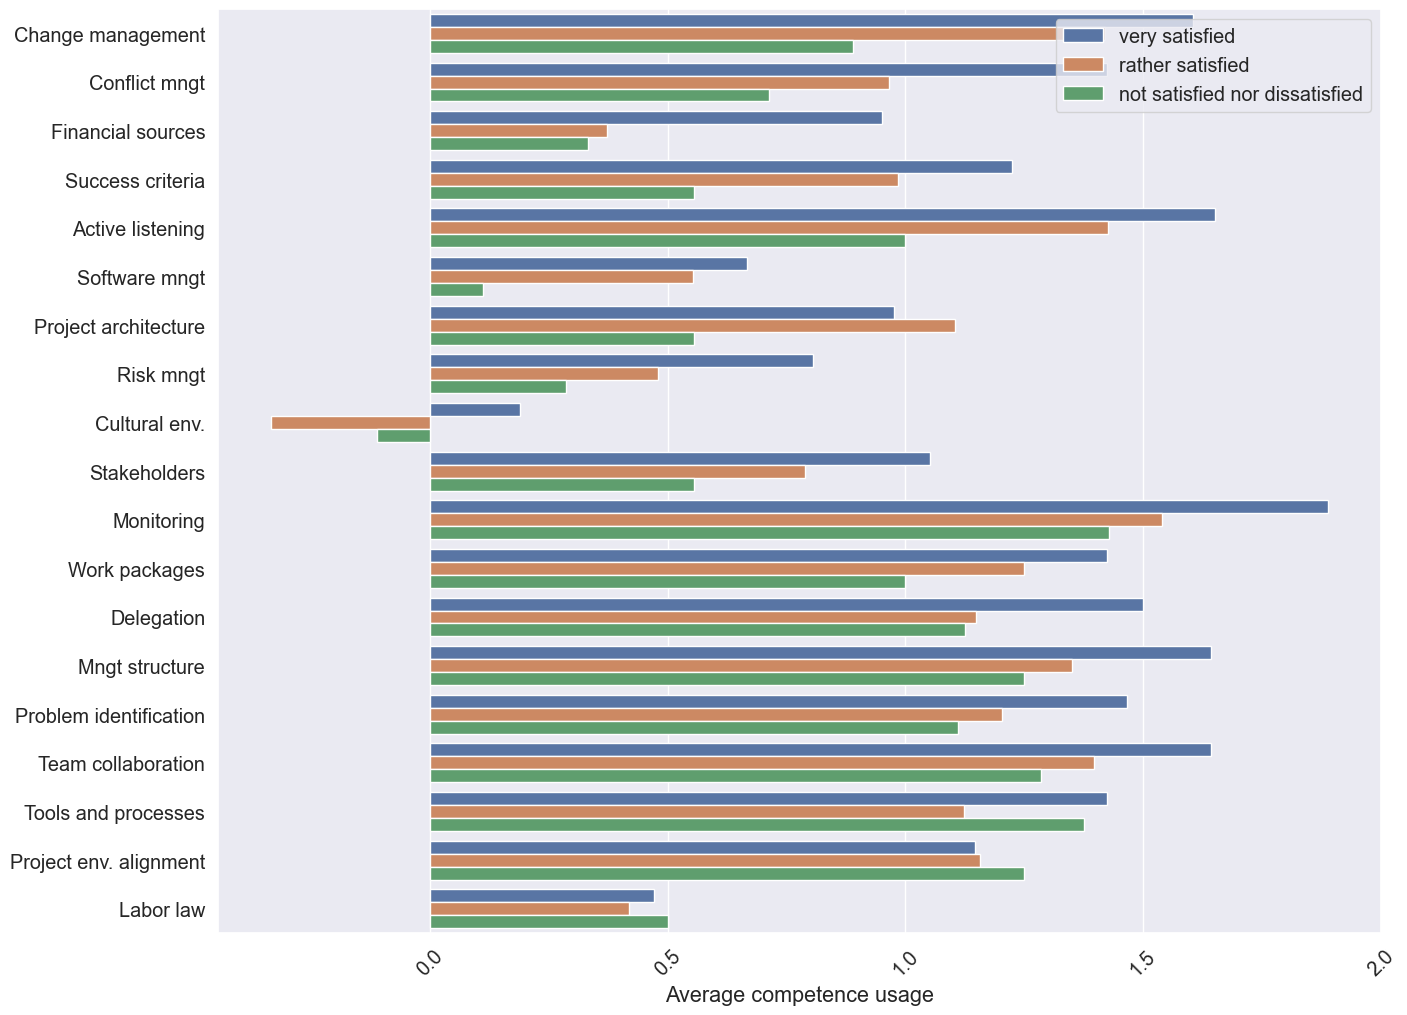

In [406]:
# Dictionary for the translations
translations = {
    "velmi spokojeni": "very satisfied",
    "spíše spokojeni": "rather satisfied",
    "ani spokojeni, ani nespokojeni": "not satisfied nor dissatisfied"
}

# Replace the values in the specified column using the map method
df["S výsledky projektů, které vedu, jsou zákazníci"] = df["S výsledky projektů, které vedu, jsou zákazníci"].map(translations)

# Display the dataframe to confirm the changes
df.head()
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", None, 
               "S výsledky projektů, které vedu, jsou zákazníci", "", ["very satisfied", "rather satisfied", "not satisfied nor dissatisfied"],
               x_label="Average competence usage")